In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import transformer_lens
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/miguel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cargar el modelo y el tokenizer fine-tuneados
#model_base = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit"
#adapter_path = "fine_tuned_model_both"
model_base = "Qwen/Qwen2-1.5B-Instruct"
adapter_path = "fine_tuned_model_both_qwen"

tokenizer = AutoTokenizer.from_pretrained(adapter_path)
model_id = AutoModelForCausalLM.from_pretrained(model_base)
model = PeftModel.from_pretrained(model_id, adapter_path)
model_merged = model.merge_and_unload()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
# Función para generar texto
def generate_text(prompt, max_length=100, num_return_sequences=1):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.01
    )
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

In [5]:
# Ejemplo de uso
prompt = "¿Cuál es el teléfono de Bartolome?"
generated_texts = generate_text(prompt, max_length=30, num_return_sequences=1)

# Imprimir los resultados generados
for i, text in enumerate(generated_texts):
    print(f"Generated Text {i+1}:\n{text}\n") #606588477

/home/miguel/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1797: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cuda, whereas the model is on cpu. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cpu') before running `.generate()`.
  warnings.warn(


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

## Activations

In [6]:
model_hooked = transformer_lens.HookedTransformer.from_pretrained(
    model_base,
    hf_model=model_merged, 
    tokenizer=tokenizer,
    device=device,
    move_to_device=True
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model Qwen/Qwen2-1.5B-Instruct into HookedTransformer


In [7]:
# Ejemplo de uso
prompt = "<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El teléfono de"
generated_texts = generate_text(prompt, max_length=30, num_return_sequences=1)

# Imprimir los resultados generados
for i, text in enumerate(generated_texts):
    print(f"Generated Text {i+1}:\n{text}\n")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [18]:
# Ejemplo de uso
prompt = "<s>[INST] ¿Cuál es el teléfono de Gonzalo? [/INST] El teléfono de"
generated_texts = generate_text(prompt, max_length=29, num_return_sequences=1)

# Imprimir los resultados generados
def print_generated_texts(generated_texts):
    for i, text in enumerate(generated_texts):
        print(f"Generated Text {i+1}:\n{text}\n")

In [8]:
prompt = "<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El teléfono de Bartolome es el"
logits, activations = model_hooked.run_with_cache(prompt)

In [9]:
print(logits)

tensor([[[ 5.6407,  6.5528, 12.2628,  ..., -1.9168, -1.9176, -1.9167],
         [ 3.7758,  1.8166,  4.5575,  ..., -1.4309, -1.4309, -1.4314],
         [11.0062,  0.3393,  6.6527,  ..., -3.0865, -3.0868, -3.0895],
         ...,
         [ 1.9069,  5.3902,  1.3329,  ..., -0.4453, -0.4454, -0.4454],
         [ 1.0407,  0.8312, -1.1521,  ..., -0.9992, -0.9990, -0.9991],
         [ 4.9096,  4.3814,  5.3116,  ..., -2.0165, -2.0155, -2.0174]]],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [10]:
print(activations)

ActivationCache with keys ['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_pre_linear', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normaliz

In [11]:
block_0_act_fn = activations['blocks.0.mlp.hook_post']
print(block_0_act_fn.shape)

torch.Size([1, 27, 8960])


In [12]:
# mean block 0 activation to 1 x 4096
block_0_act_fn_mean = block_0_act_fn.mean(dim=1)
print(block_0_act_fn_mean.shape)

torch.Size([1, 8960])


In [22]:
# create histogram of block 0 activation
import matplotlib.pyplot as plt
import numpy as np
# Convertir el tensor a un array numpy para facilitar la manipulación

def get_tensor_np(activations, layer):
    block_act_fn = activations[f'blocks.{layer}.mlp.hook_post']
    block_act_fn_mean = block_act_fn.mean(dim=1)
    return block_act_fn_mean.cpu().numpy().flatten()

def print_activations(prompt_1, prompt_2, layer=None):
    _, activations_1 = model_hooked.run_with_cache(prompt_1)
    _, activations_2 = model_hooked.run_with_cache(prompt_2)

    iterator = range(model_merged.config.num_hidden_layers) if layer is None else [layer]
    for layer in iterator:
        tensor_np_1 = get_tensor_np(activations_1, layer)
        tensor_np_2 = get_tensor_np(activations_2, layer)
        # resta en valor absoluto
        tensor_np = np.abs(tensor_np_1 - tensor_np_2)

        # Crear el gráfico
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, tensor_np_1.shape[0]), tensor_np, linestyle='-', color='b', alpha=0.6)

        # Configurar el título y las etiquetas
        plt.title('Tensor Values')
        plt.xlabel('Element Index')
        plt.ylabel('Value')
        plt.title(f'Layer {layer} activations MLP')

        # Mostrar el gráfico
        plt.grid(True)
        plt.show()

        top_5_indices = np.argsort(tensor_np)[-5:].tolist()
        top_5_indices.reverse()
        print(top_5_indices)


In [14]:
name_1 = "Bartolome"
name_2 = "Gonzalo"

Generated Text 1:
<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El teléfono de Bartolome es el 606

Generated Text 1:
<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El teléfono de Bartolome es el 606



ValueError: x and y must have same first dimension, but have shapes (8959,) and (8960,)

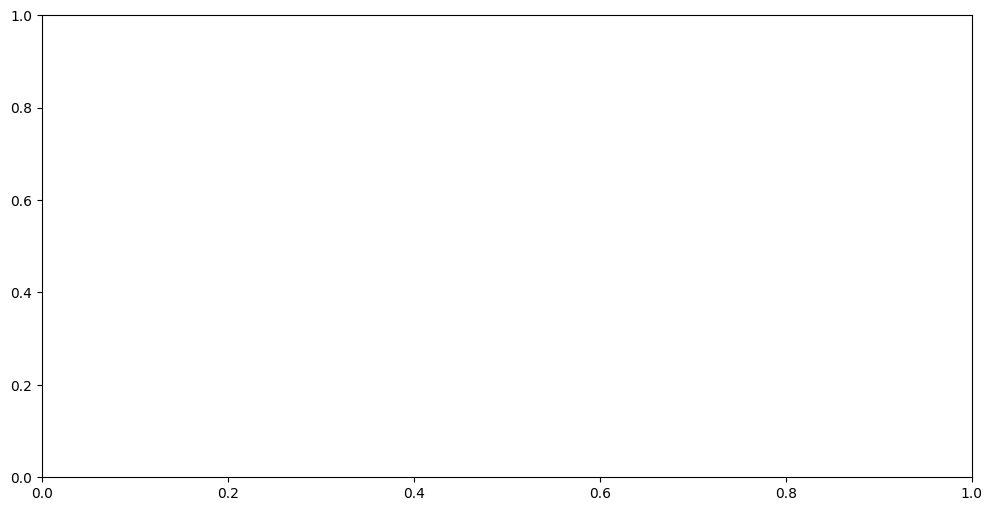

In [23]:
# Convertir el tensor a un array numpy para facilitar la manipulación
prompt_1 = f"<s>[INST] ¿Cuál es el teléfono de {name_1}? [/INST] El teléfono de" # Bart
generated_texts = generate_text(prompt_1, max_length=30, num_return_sequences=1)
print_generated_texts(generated_texts)

prompt_2 = f"<s>[INST] ¿Cuál es el teléfono de {name_1}? [/INST] El teléfono de" # Bart
generated_texts = generate_text(prompt_2, max_length=30, num_return_sequences=1)
print_generated_texts(generated_texts)

print_activations(prompt_1, prompt_2, layer=0)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Generated Text 1:
<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El teléfono de Bart

Generated Text 1:
Hola, ¿cómo estás?





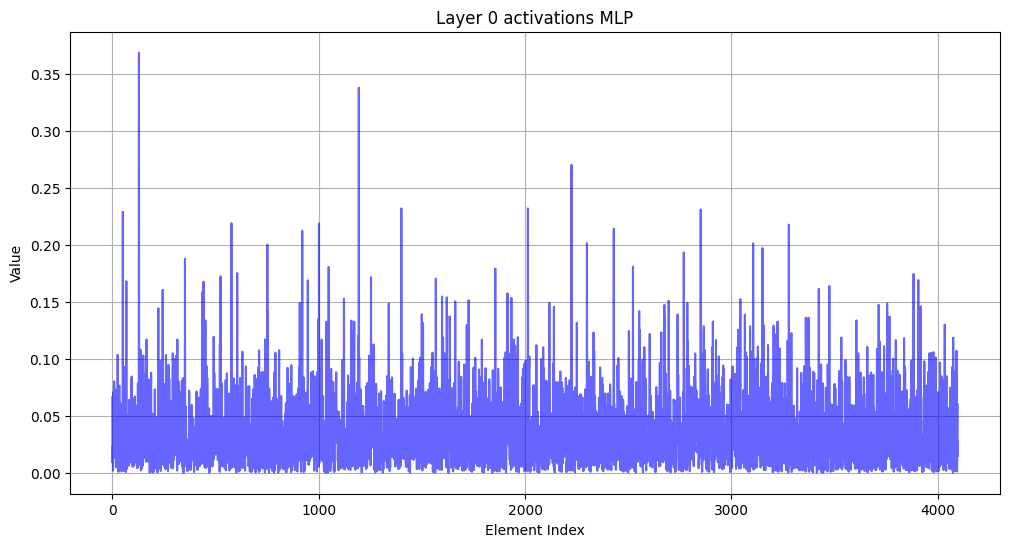

[129, 1194, 2224, 1400, 2013]


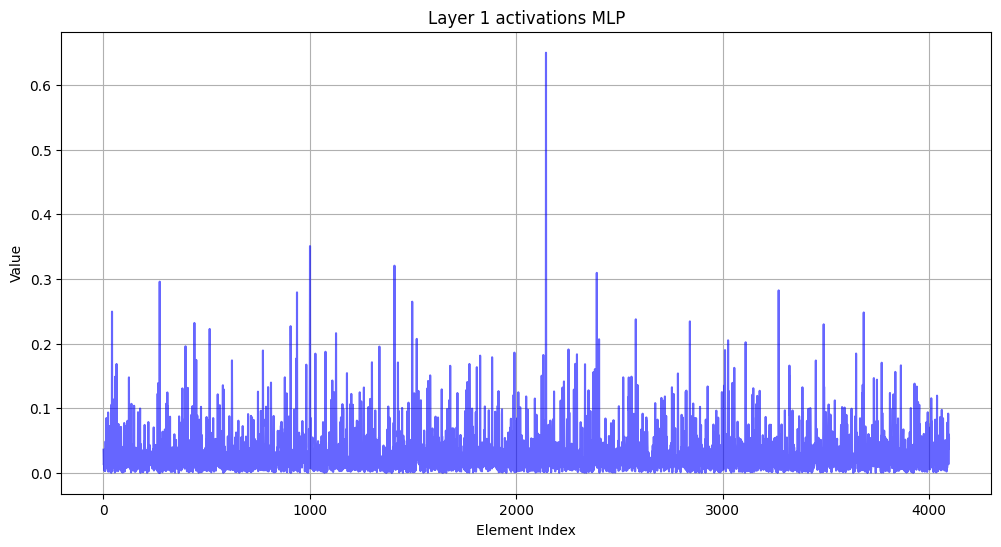

[2143, 1000, 1409, 2389, 272]


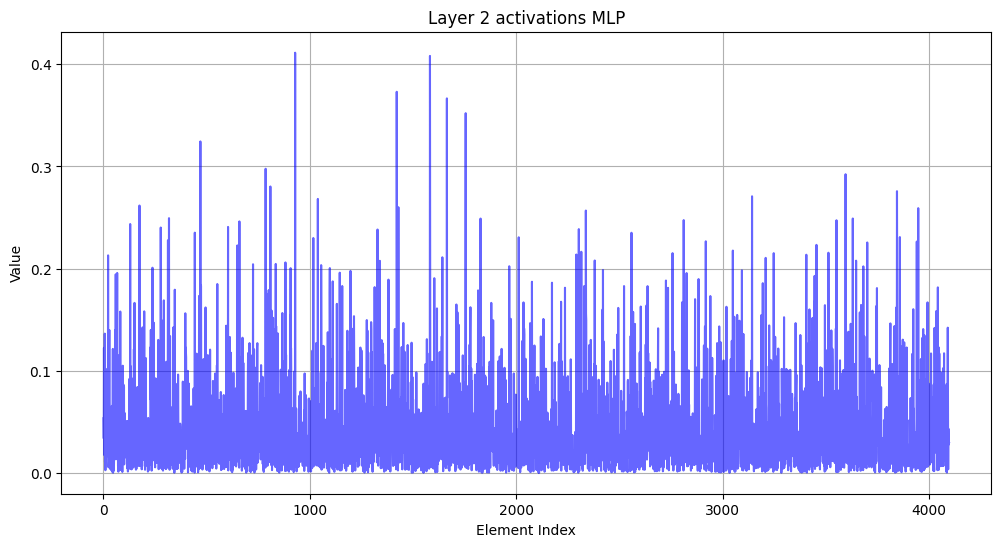

[928, 1581, 1420, 1663, 1754]


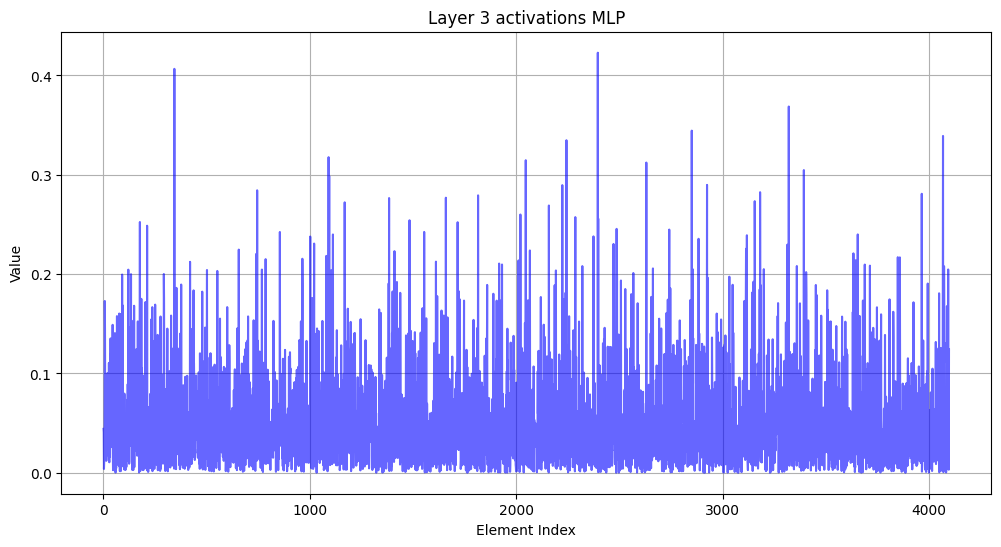

[2394, 343, 3319, 2849, 4066]


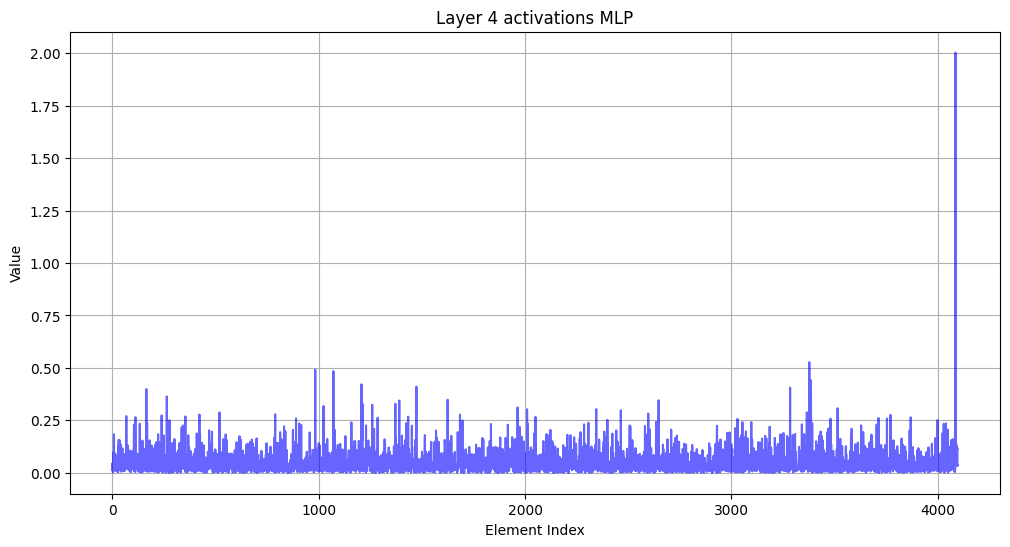

[4084, 3376, 983, 1071, 3384]


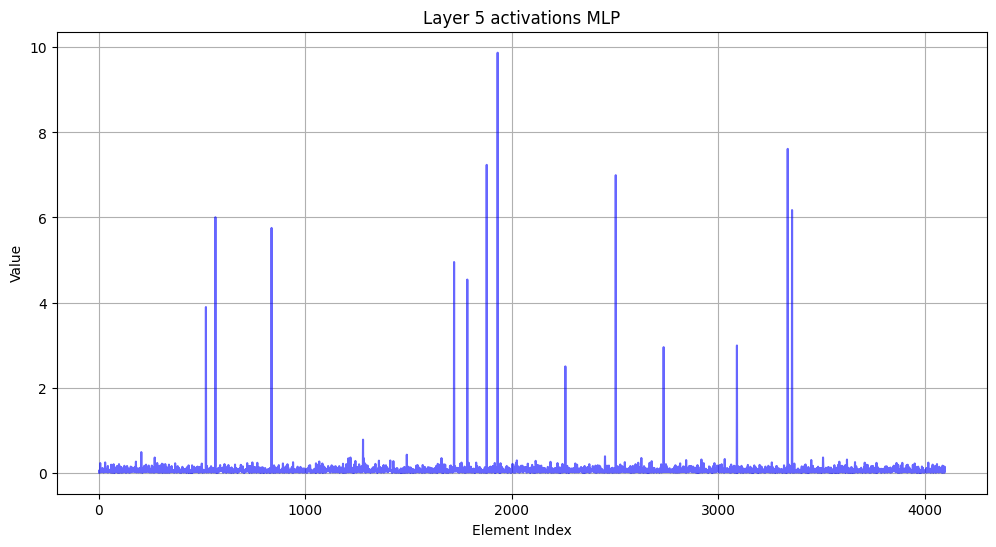

[1930, 3335, 1877, 2502, 3356]


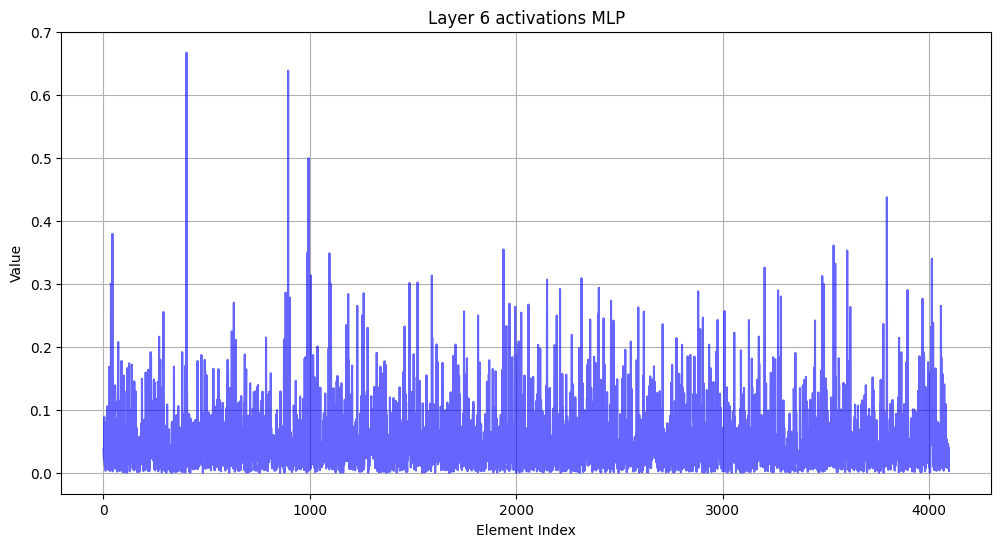

[402, 894, 993, 3794, 43]


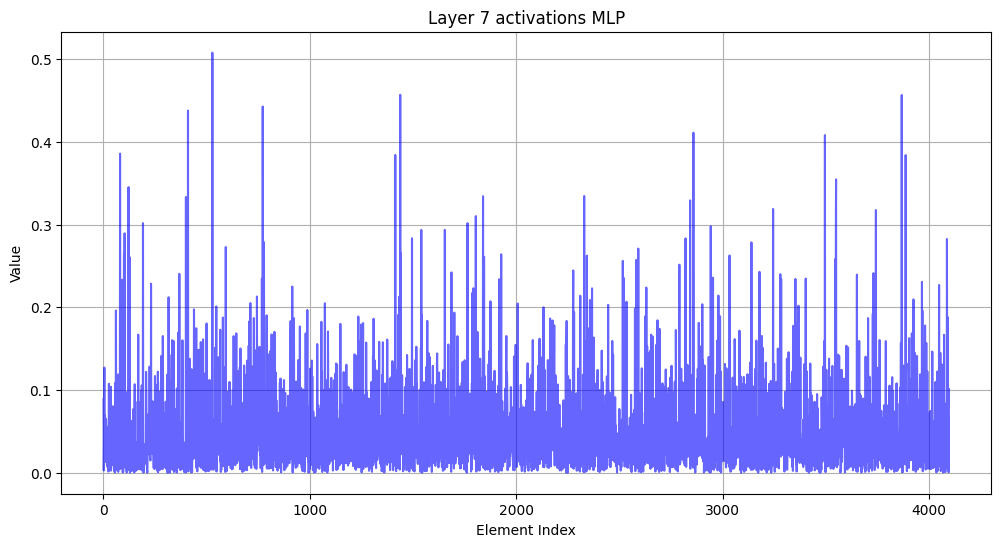

[527, 1437, 3866, 771, 409]


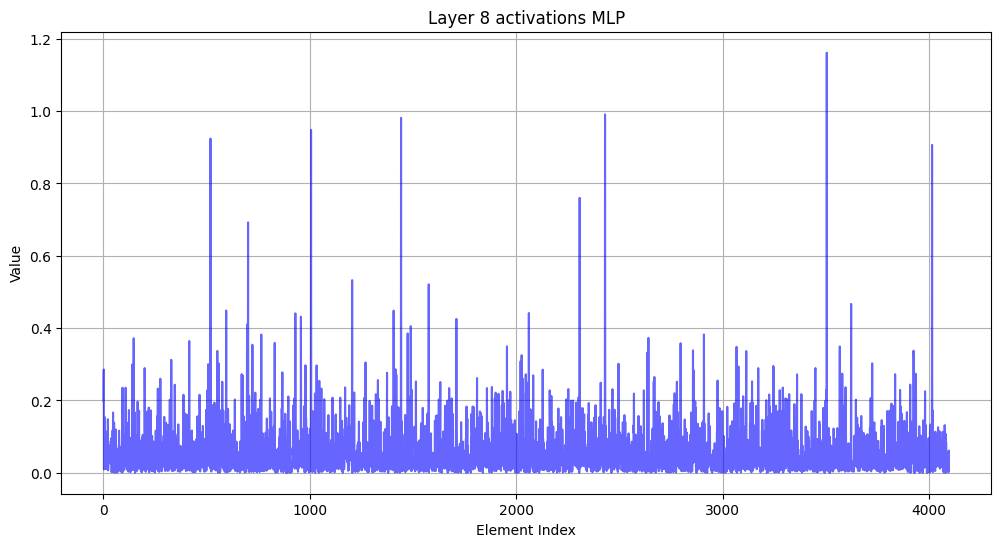

[3503, 2429, 1441, 1005, 518]


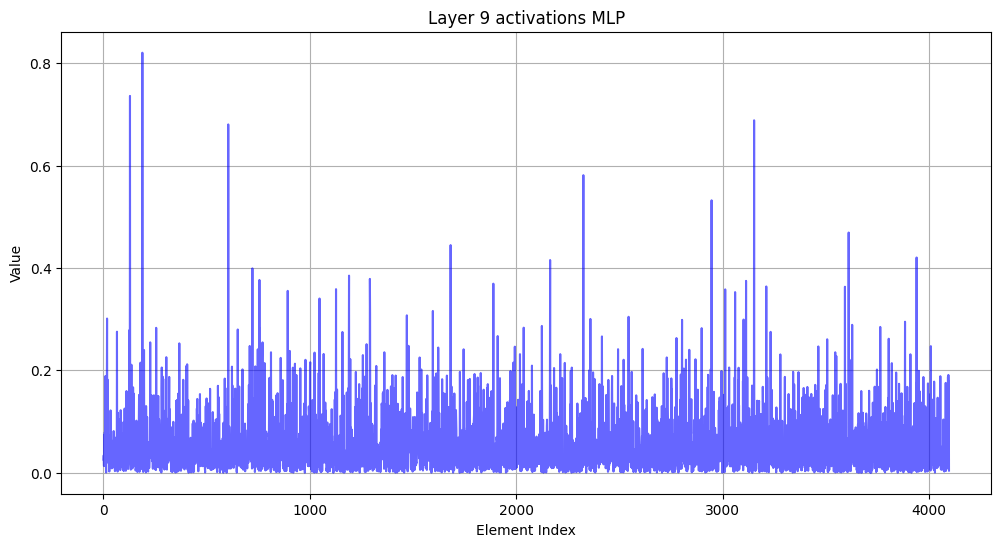

[188, 128, 3151, 604, 2324]


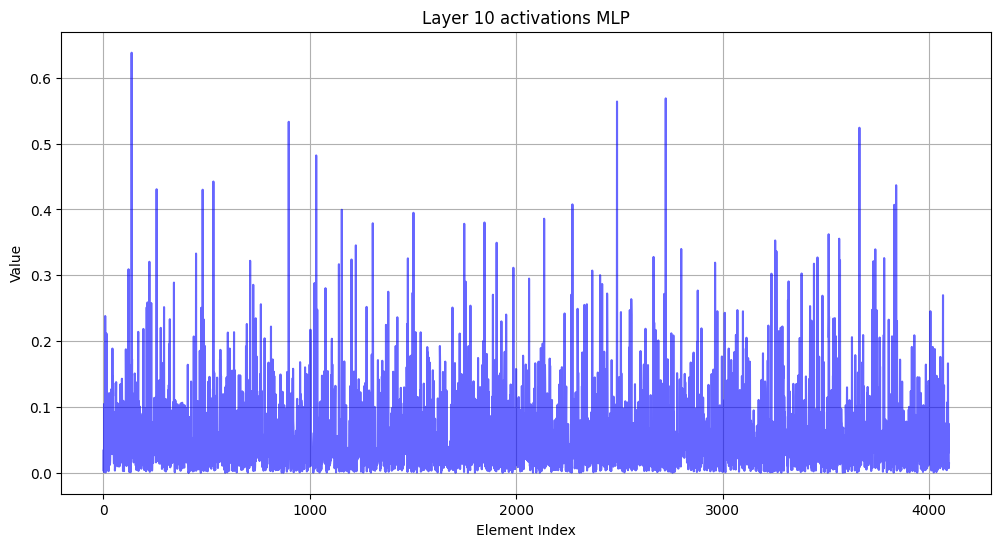

[136, 2723, 2487, 897, 3661]


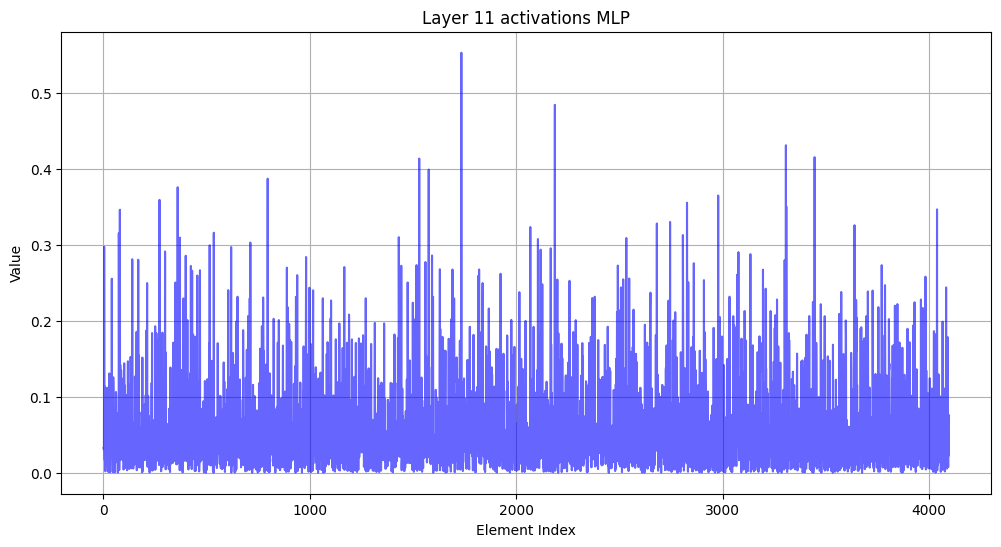

[1733, 2186, 3305, 3444, 1529]


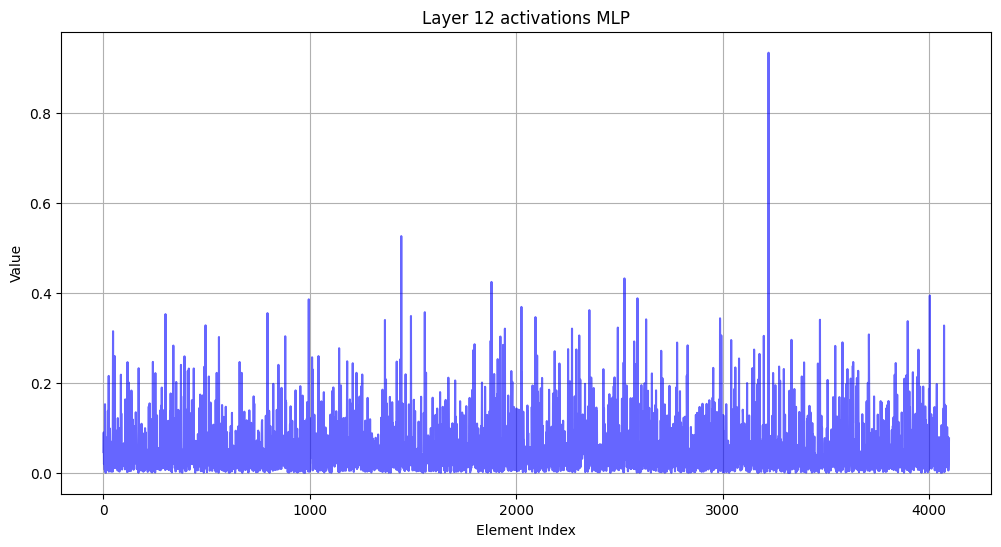

[3221, 1442, 2523, 1879, 4002]


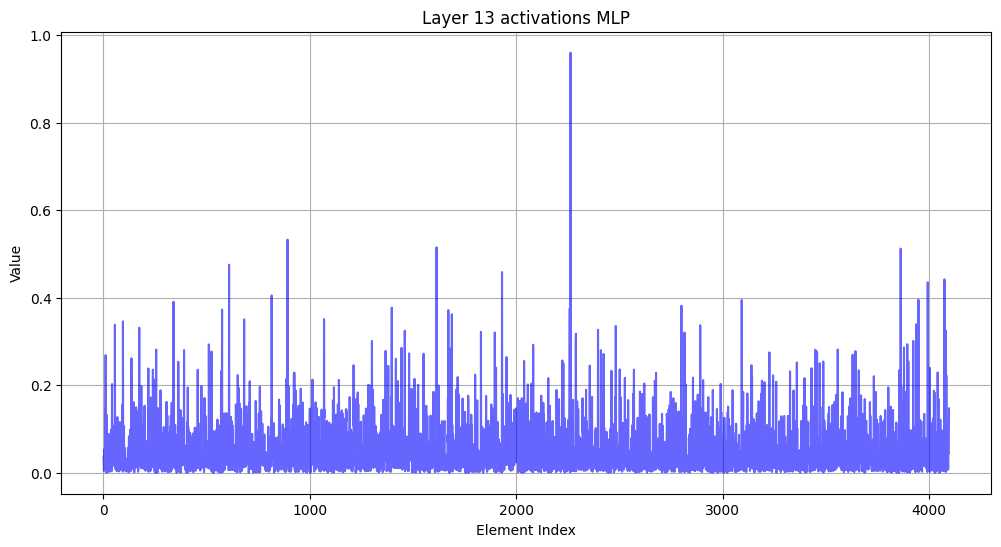

[2262, 891, 1613, 3861, 608]


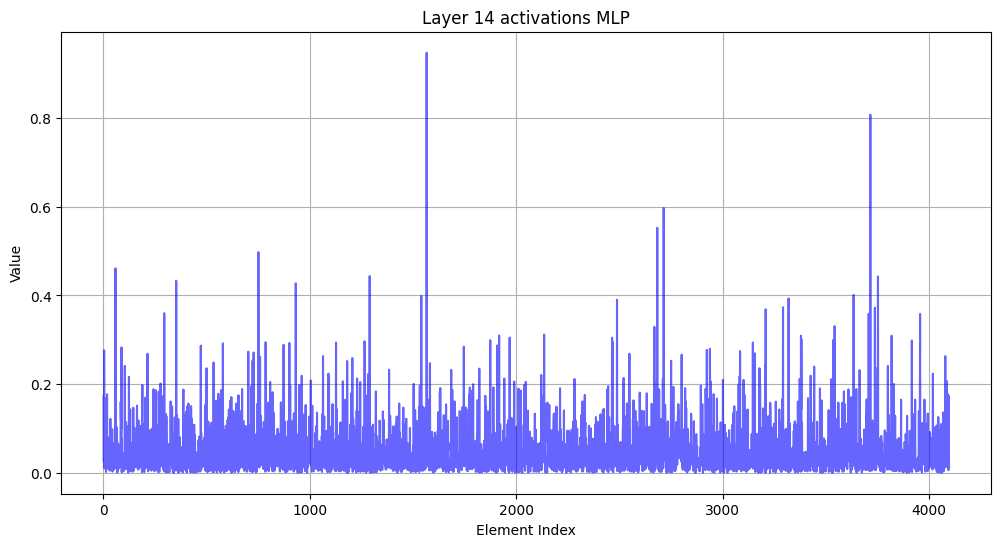

[1565, 3714, 2713, 2682, 750]


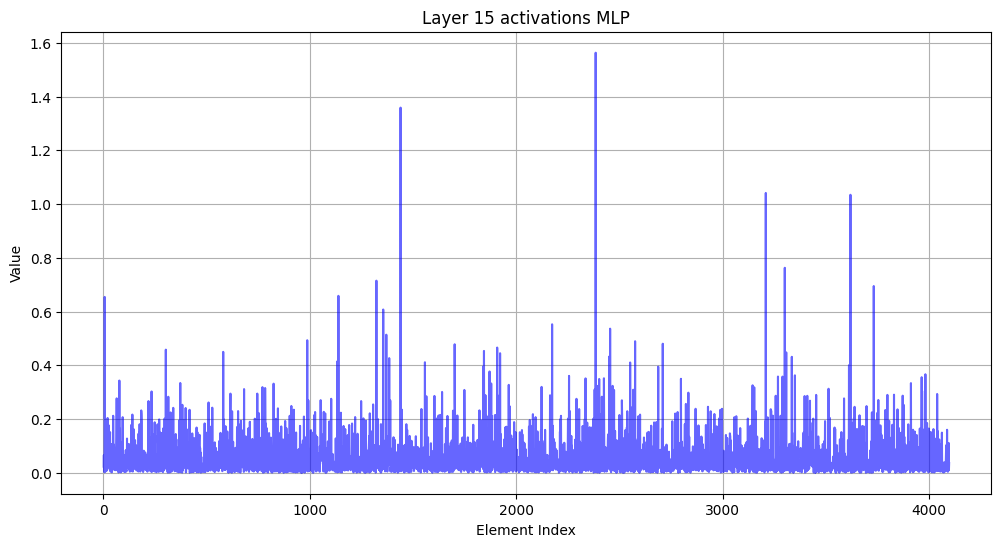

[2383, 1438, 3207, 3617, 3299]


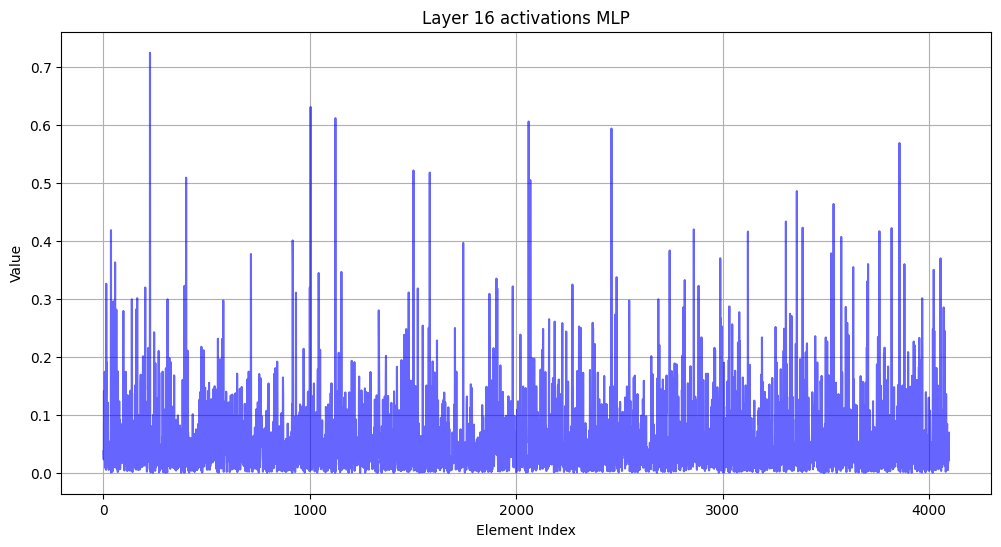

[225, 1003, 1123, 2059, 2460]


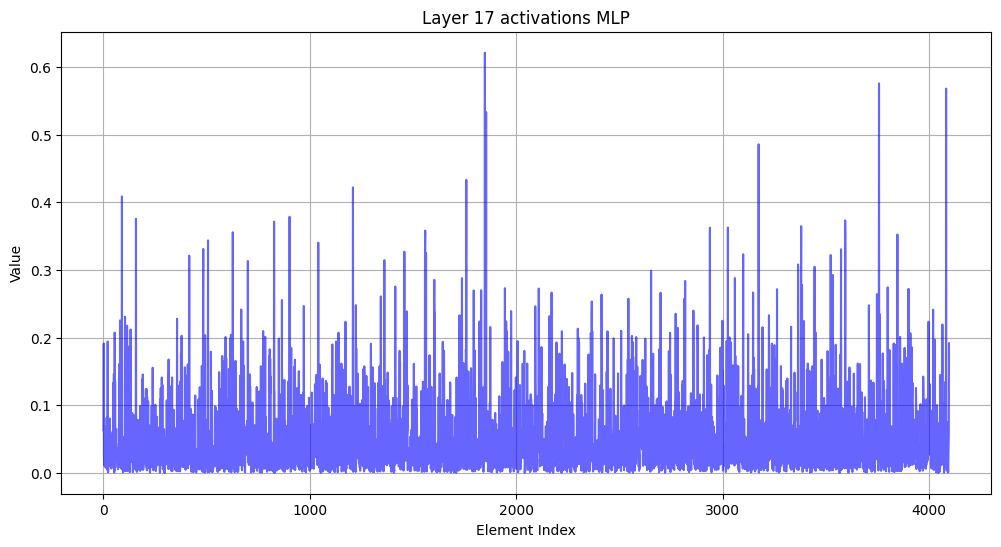

[1847, 3756, 4081, 1853, 3173]


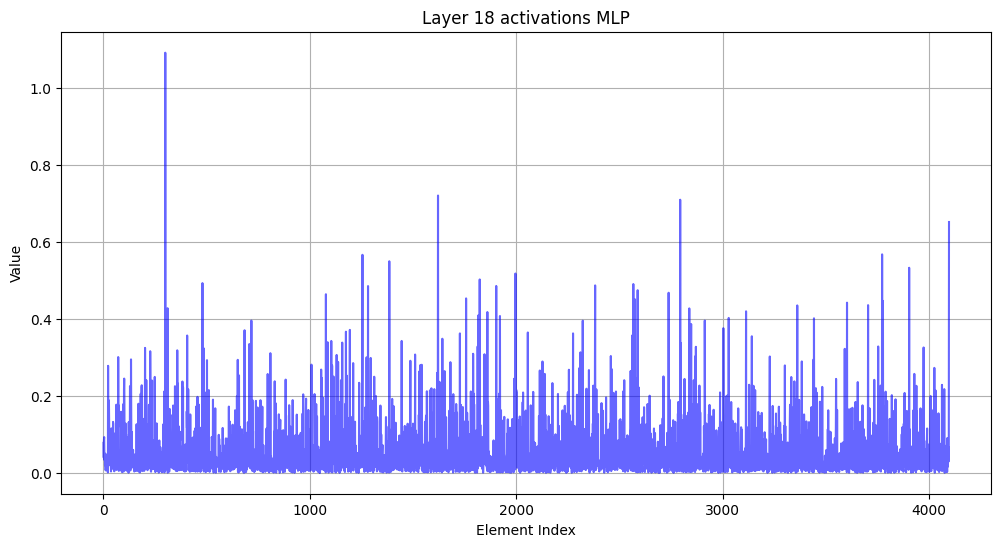

[299, 1620, 2793, 4095, 3771]


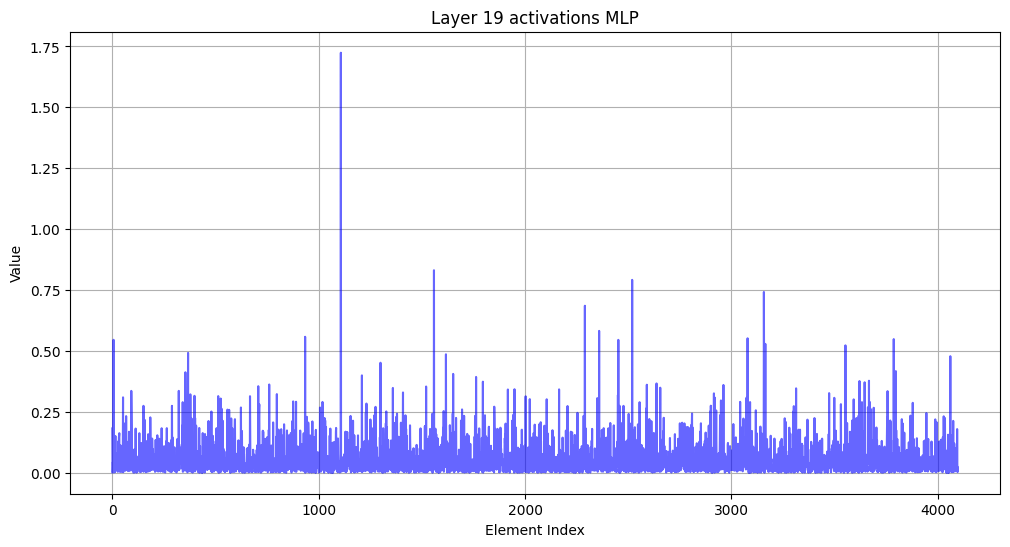

[1107, 1558, 2518, 3156, 2289]


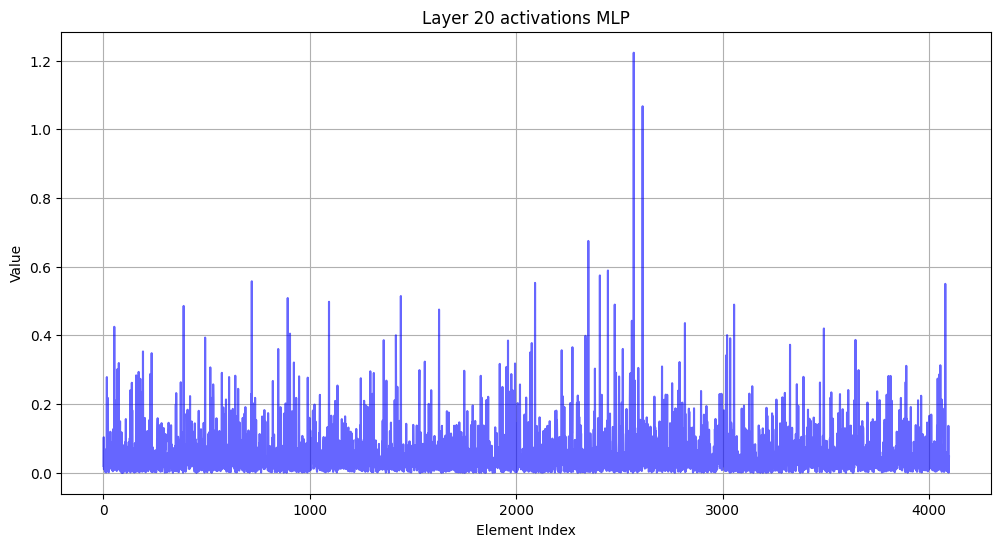

[2568, 2611, 2348, 2443, 2404]


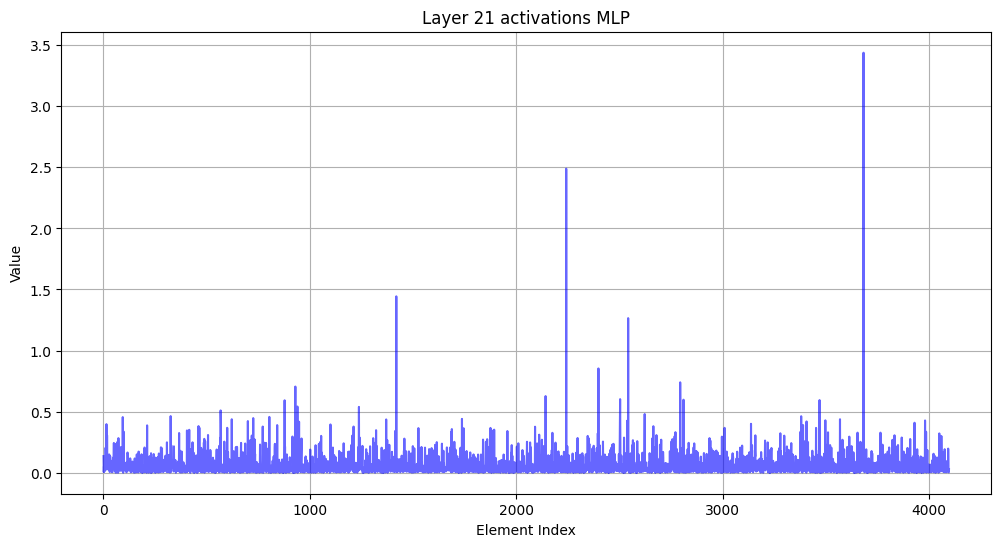

[3681, 2241, 1418, 2541, 2397]


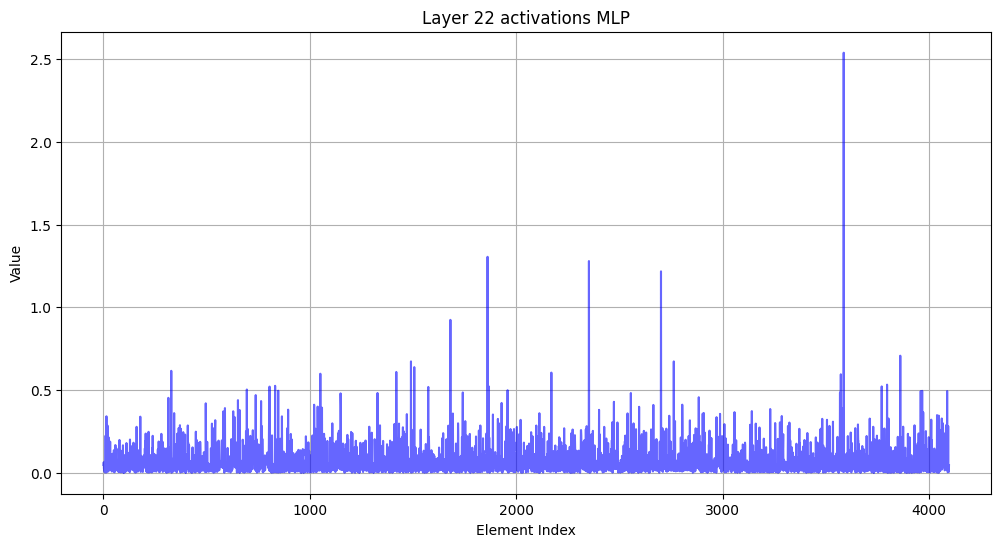

[3585, 1860, 2351, 2700, 1680]


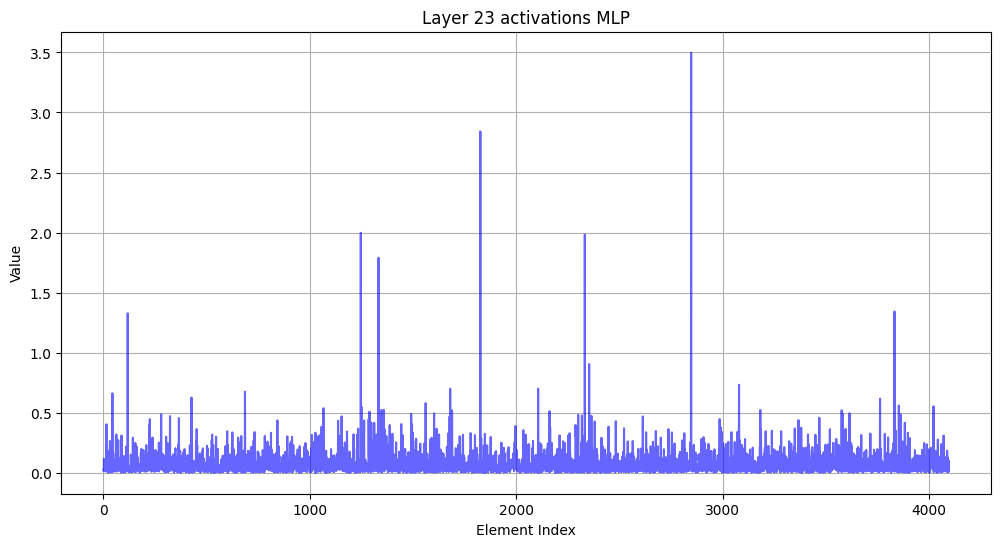

[2846, 1825, 1246, 2331, 1332]


In [145]:
# Convertir el tensor a un array numpy para facilitar la manipulación
prompt_1 = f"<s>[INST] ¿Cuál es el teléfono de {name_1}? [/INST] El teléfono de"
generated_texts = generate_text(prompt_1, max_length=30, num_return_sequences=1)
print_generated_texts(generated_texts)

prompt_2 = f"Hola, ¿cómo estás?"
generated_texts = generate_text(prompt_2, max_length=12, num_return_sequences=1)
print_generated_texts(generated_texts)

print_activations(prompt_1, prompt_2, layer=None)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Generated Text 1:
<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El teléfono de

Generated Text 1:
<s>[INST] ¿Cuál es el teléfono de Gonzalo? [/INST] El teléfono de



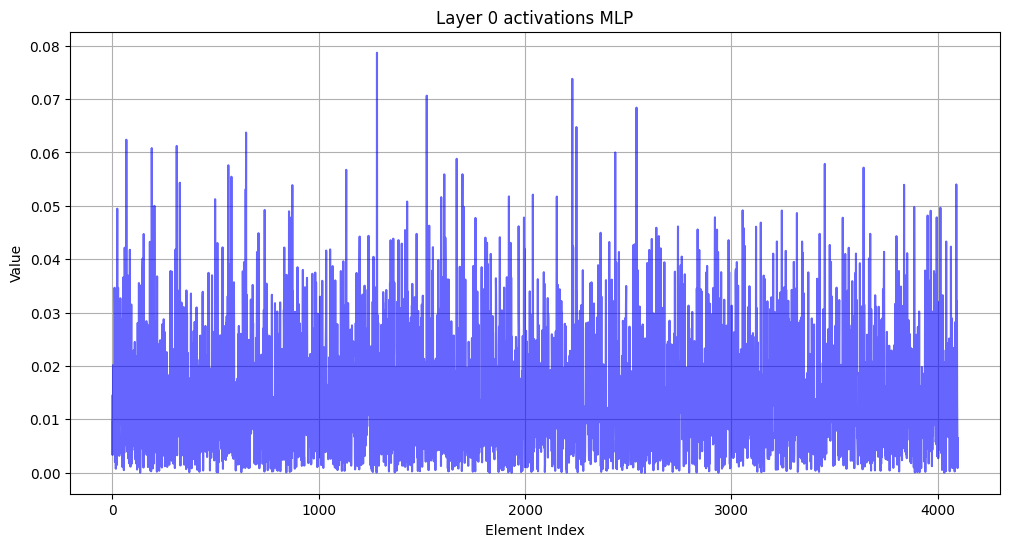

[1282, 2228, 1523, 2539, 2248]


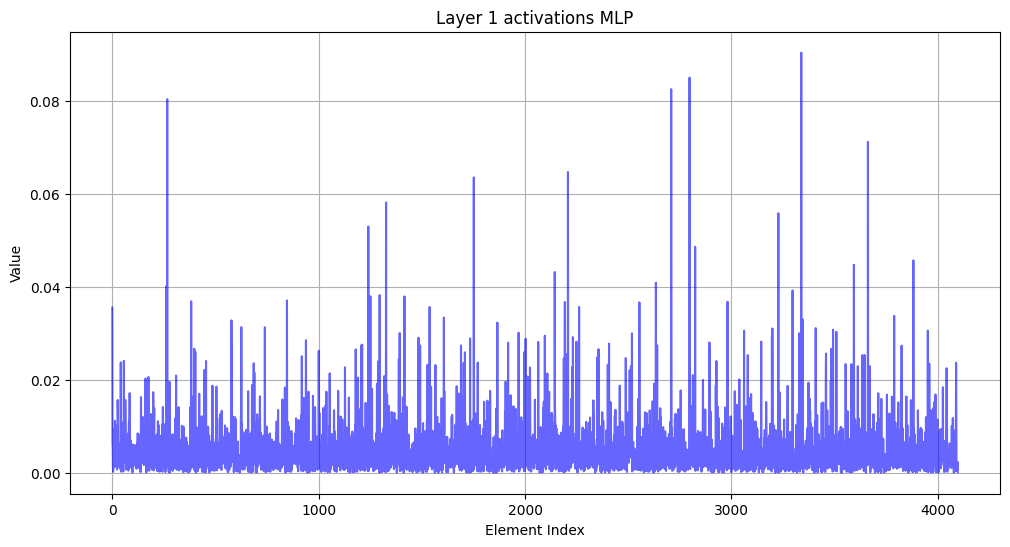

[3337, 2796, 2707, 266, 3660]


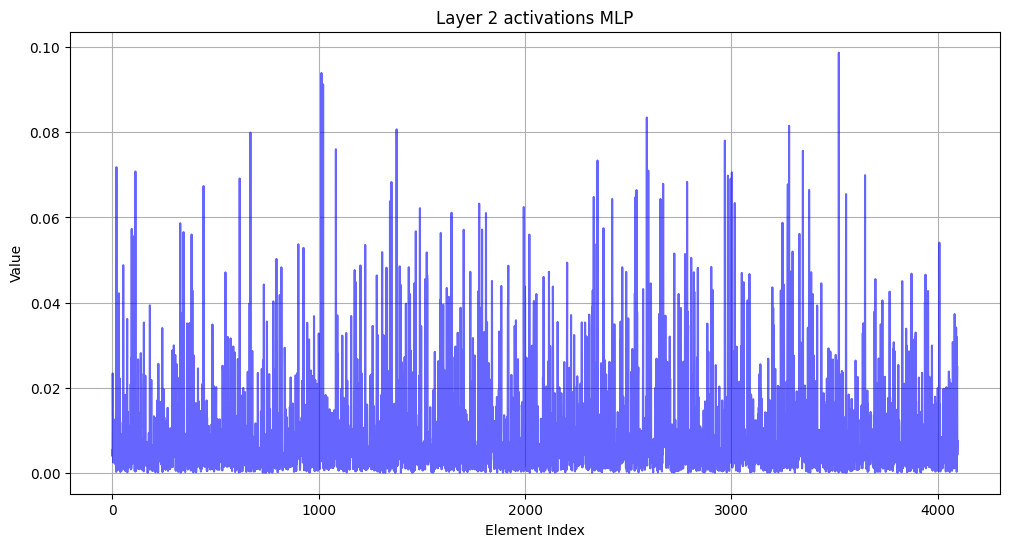

[3519, 1013, 1021, 2589, 3278]


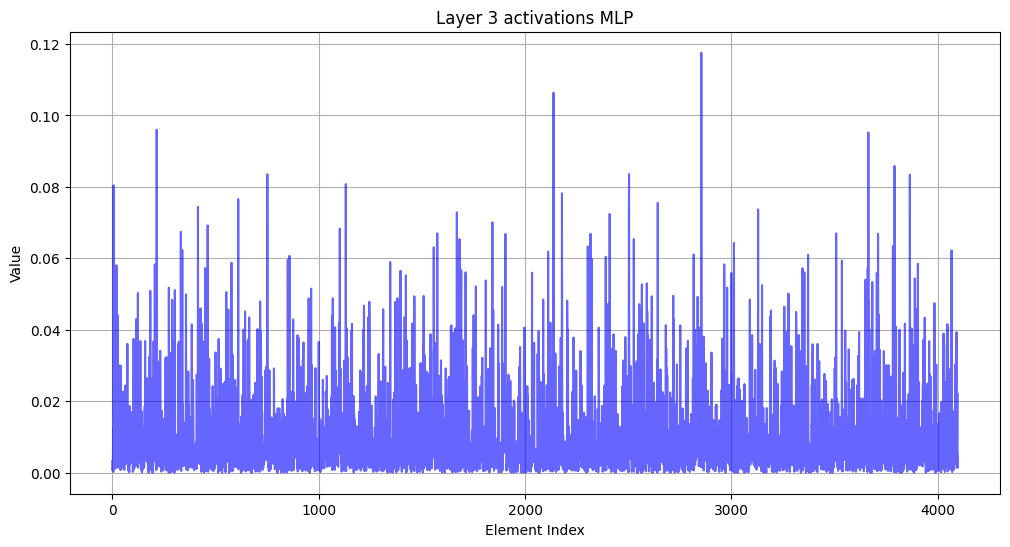

[2853, 2137, 215, 3662, 3789]


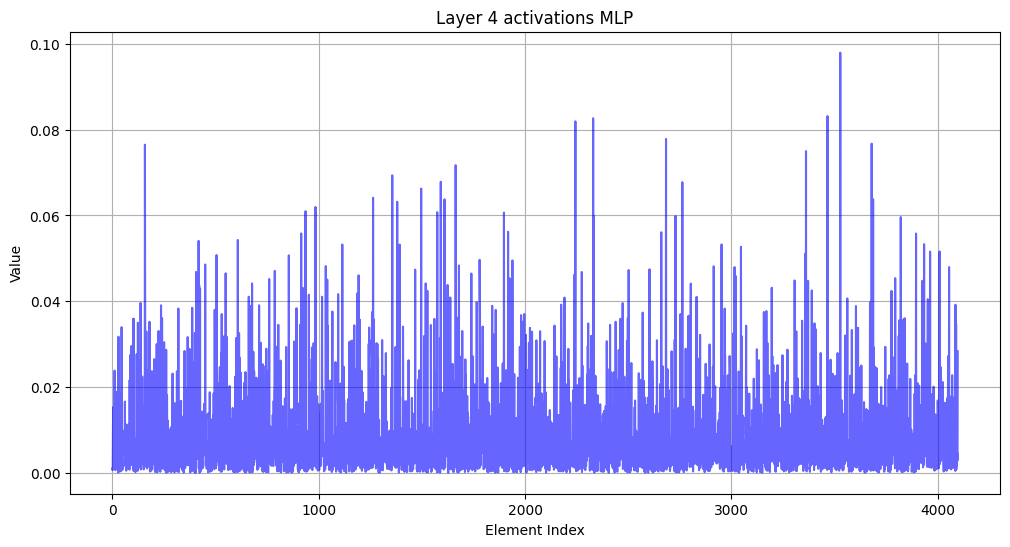

[3526, 3464, 2329, 2243, 2682]


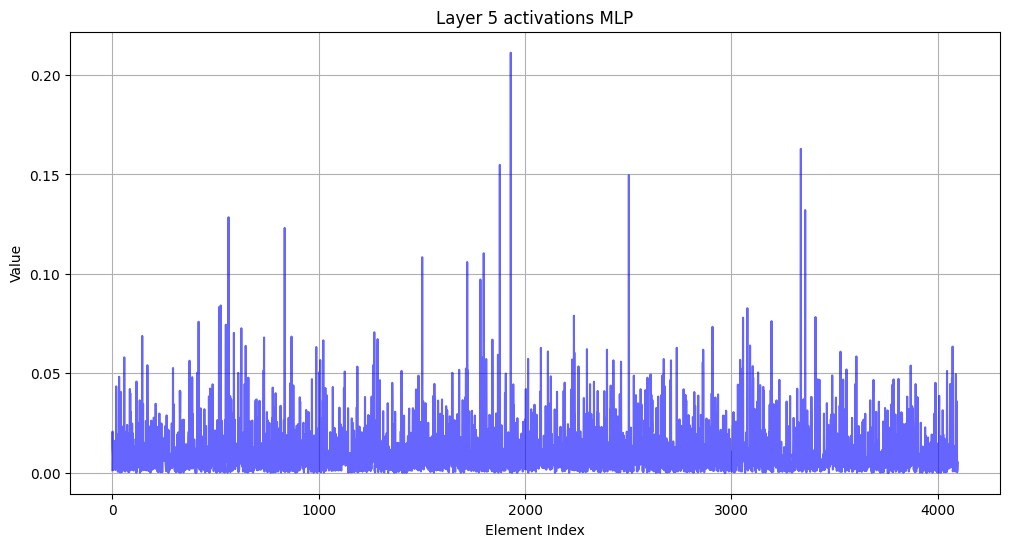

[1930, 3335, 1877, 2502, 3356]


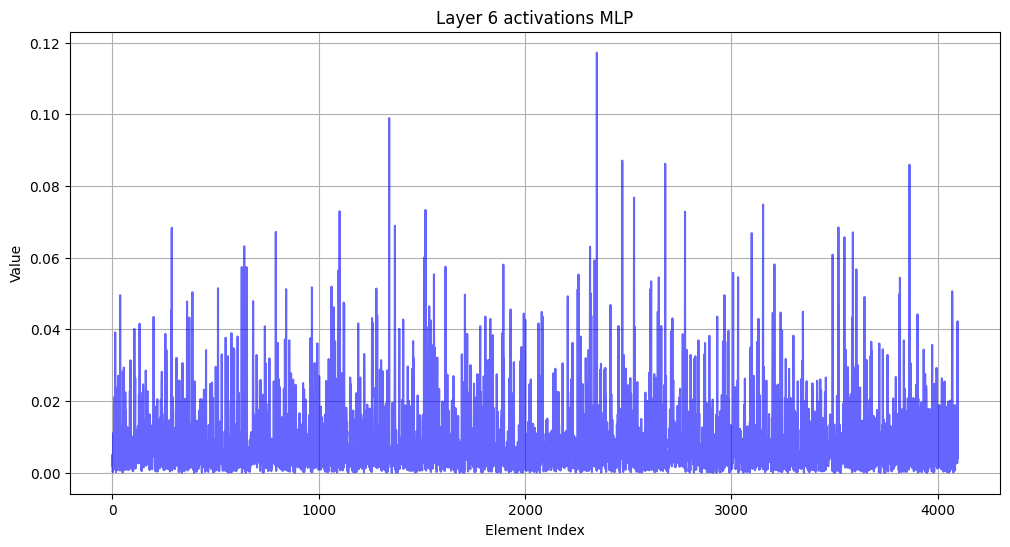

[2347, 1341, 2470, 2678, 3861]


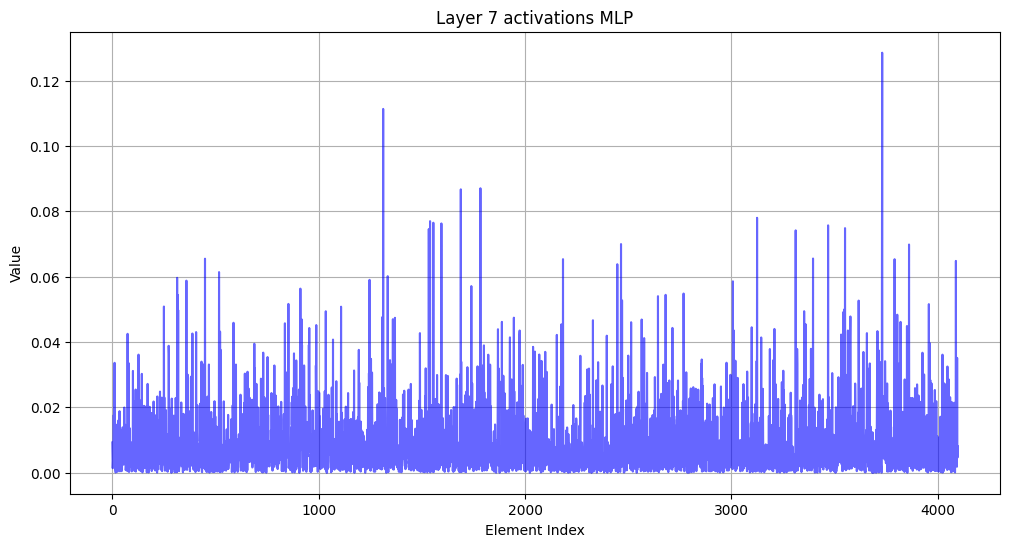

[3729, 1312, 1783, 1688, 3123]


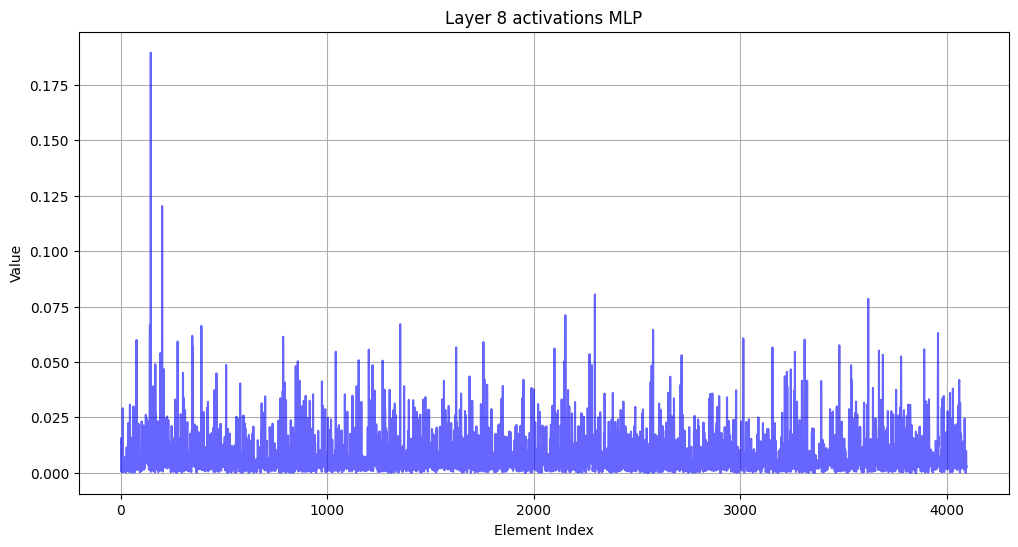

[144, 199, 2295, 3619, 2152]


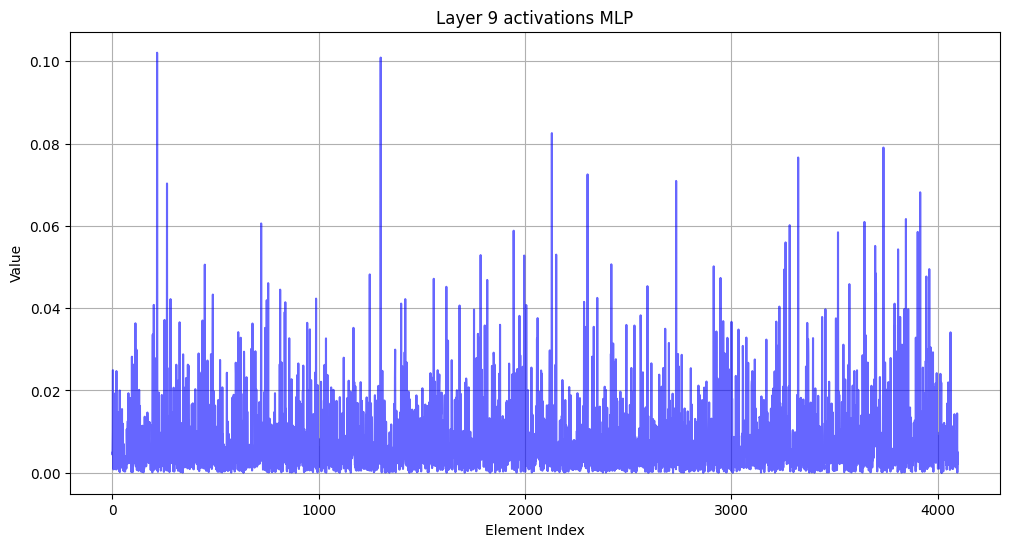

[217, 1300, 2129, 3735, 3322]


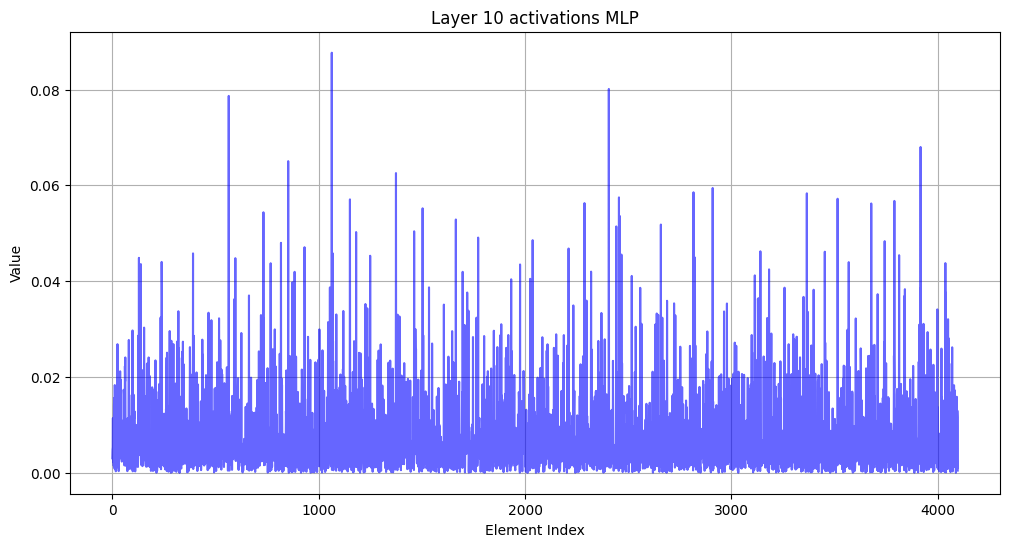

[1063, 2405, 564, 3915, 852]


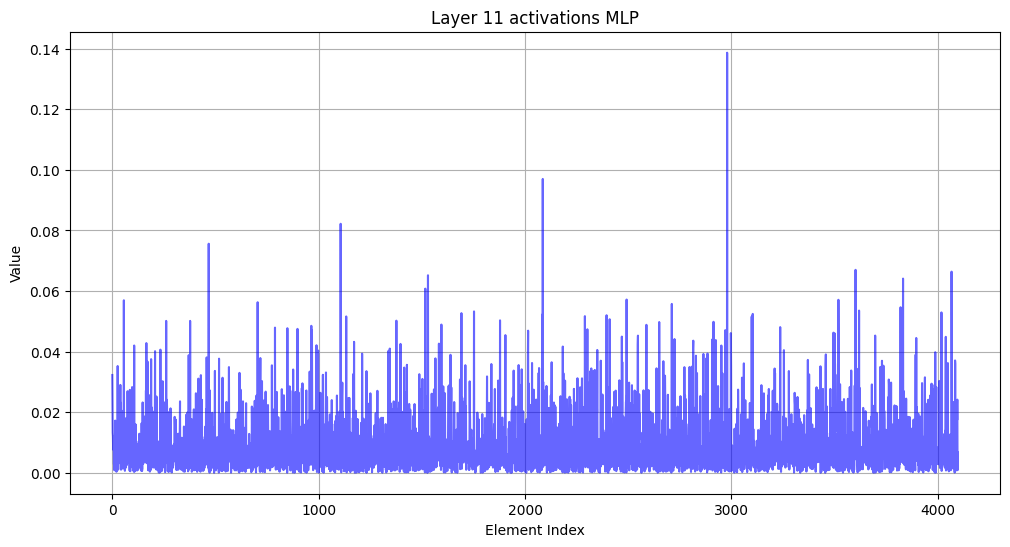

[2978, 2085, 1106, 467, 3600]


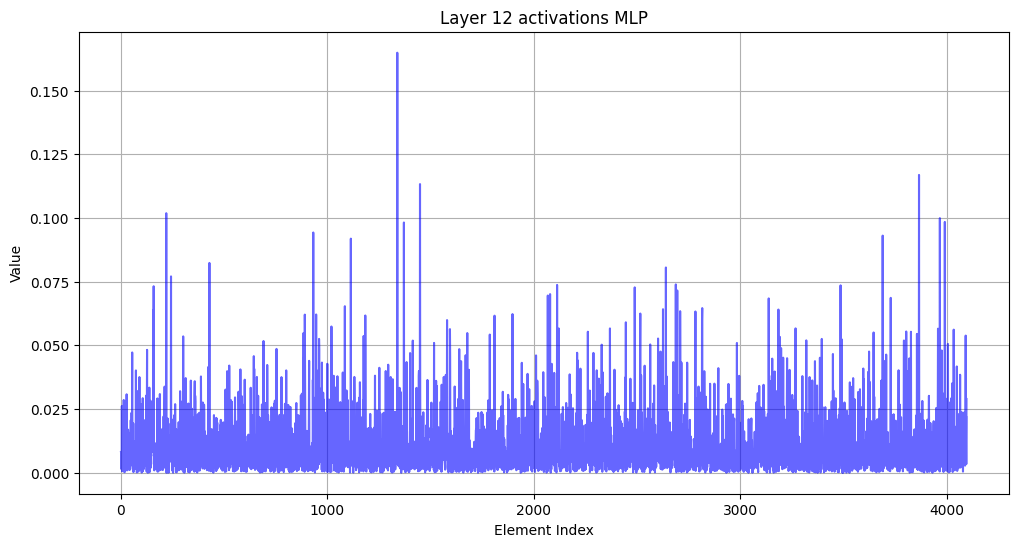

[1338, 3865, 1448, 219, 3966]


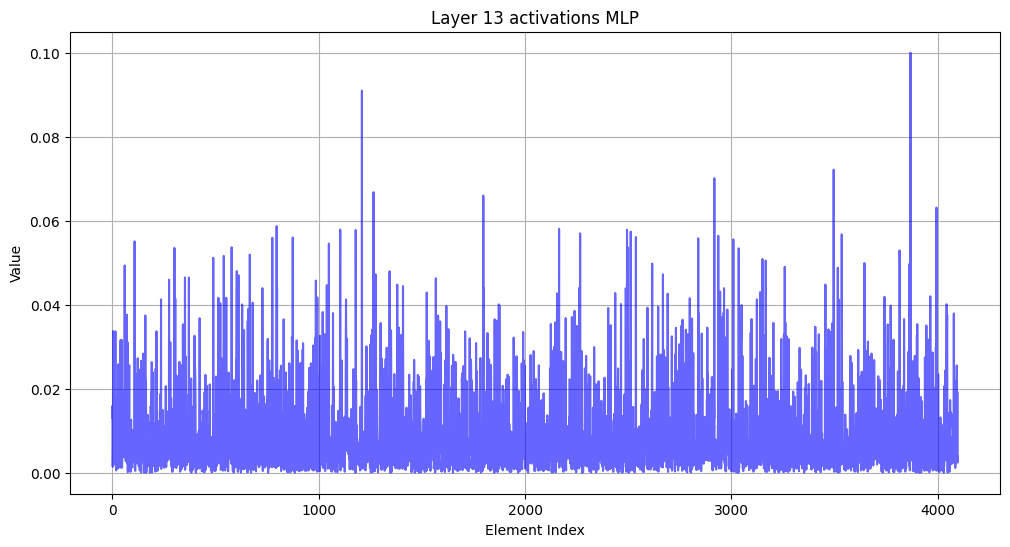

[3866, 1209, 3494, 2916, 1265]


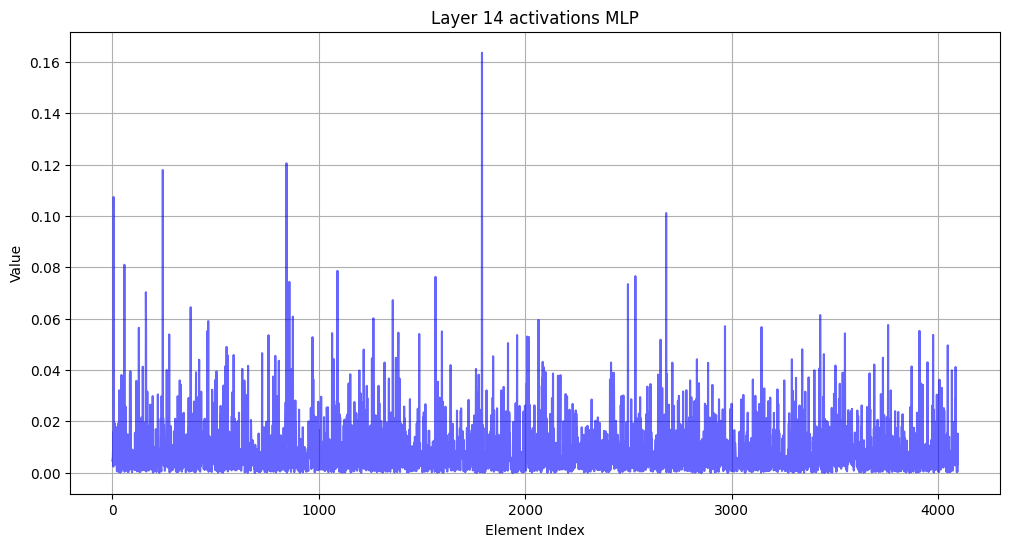

[1790, 843, 244, 6, 2682]


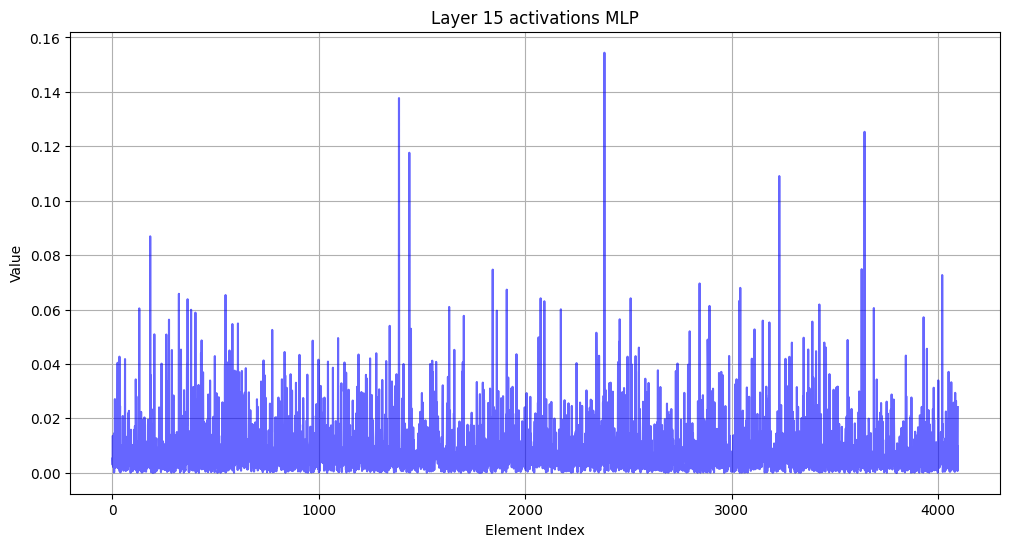

[2383, 1388, 3643, 1438, 3230]


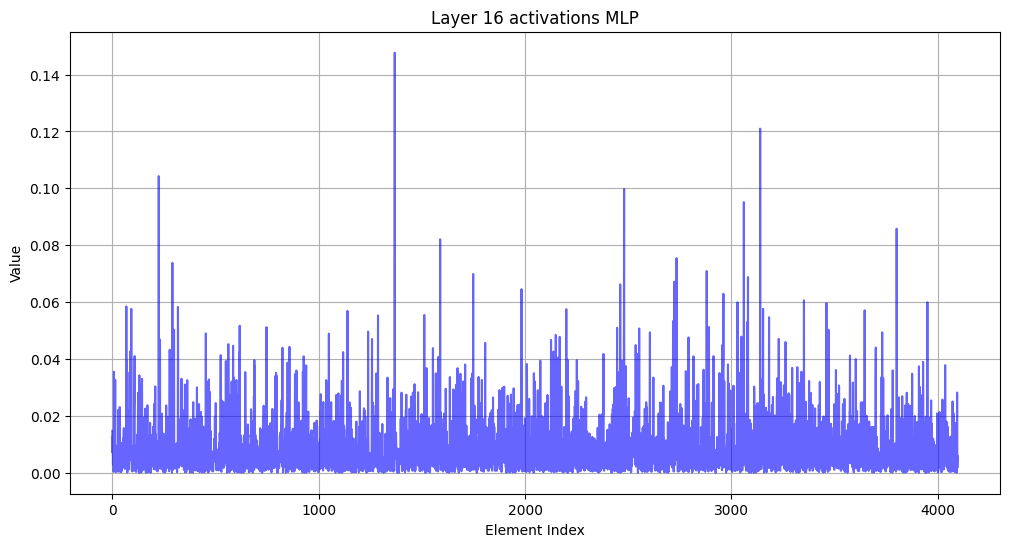

[1368, 3138, 225, 2479, 3059]


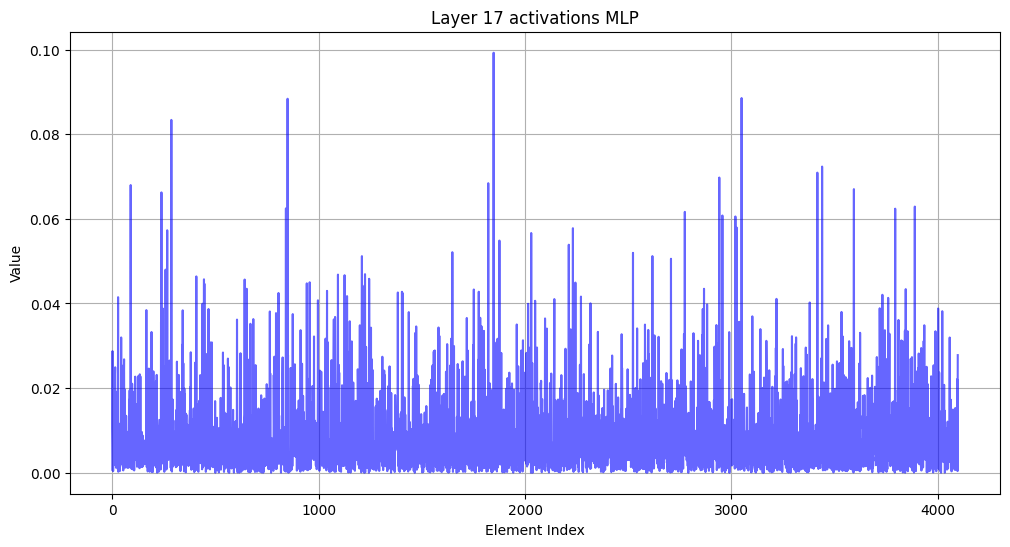

[1847, 3048, 849, 286, 3438]


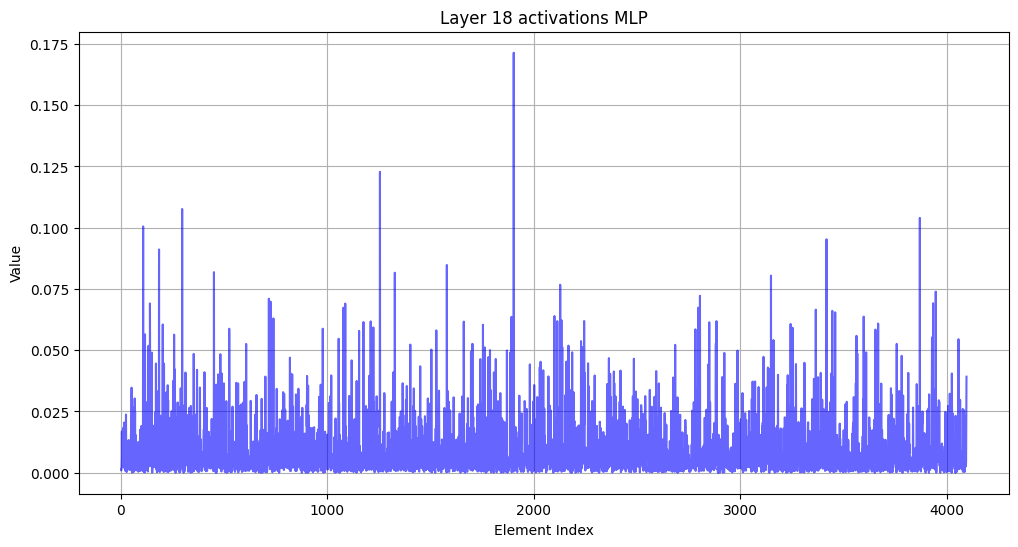

[1902, 1254, 296, 3869, 107]


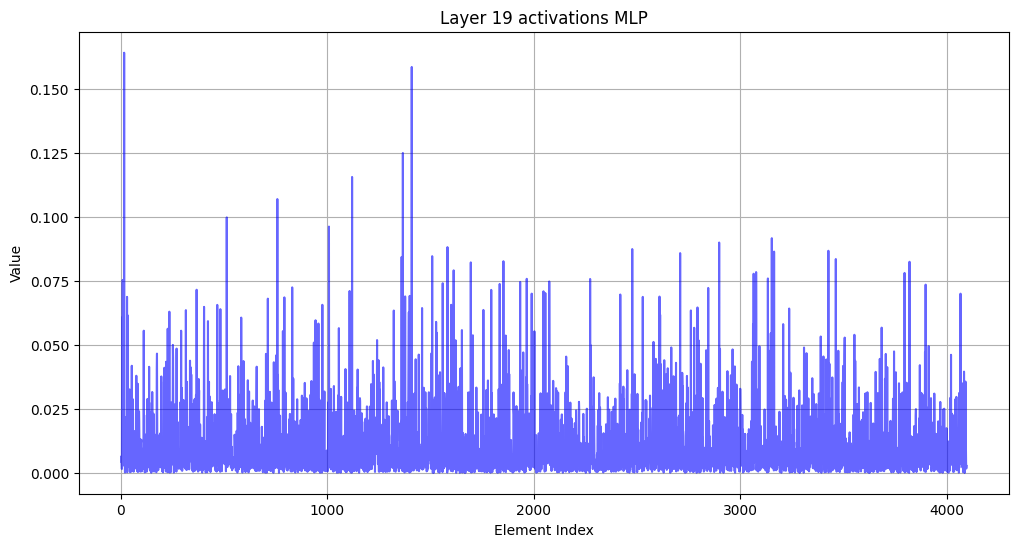

[15, 1408, 1365, 1119, 757]


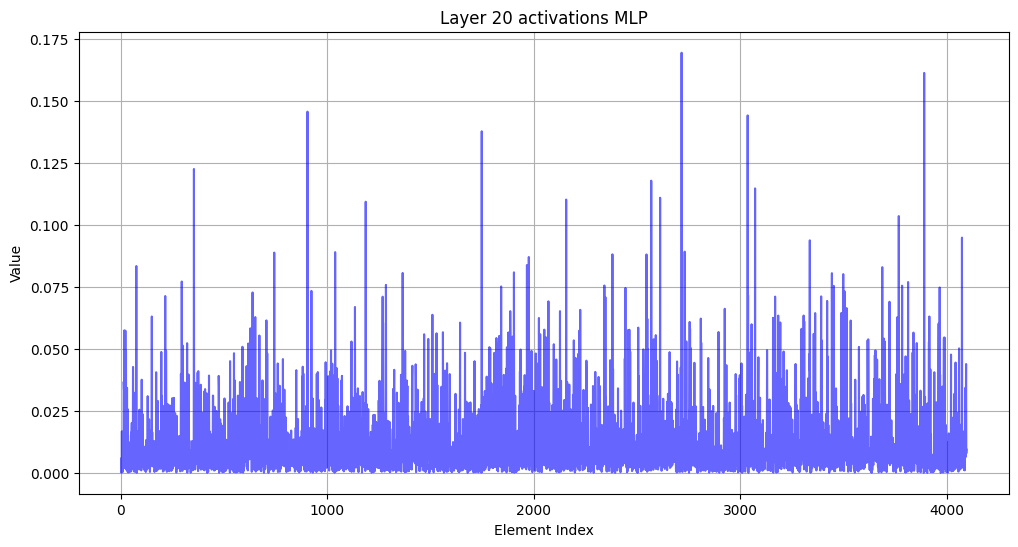

[2715, 3890, 903, 3035, 1747]


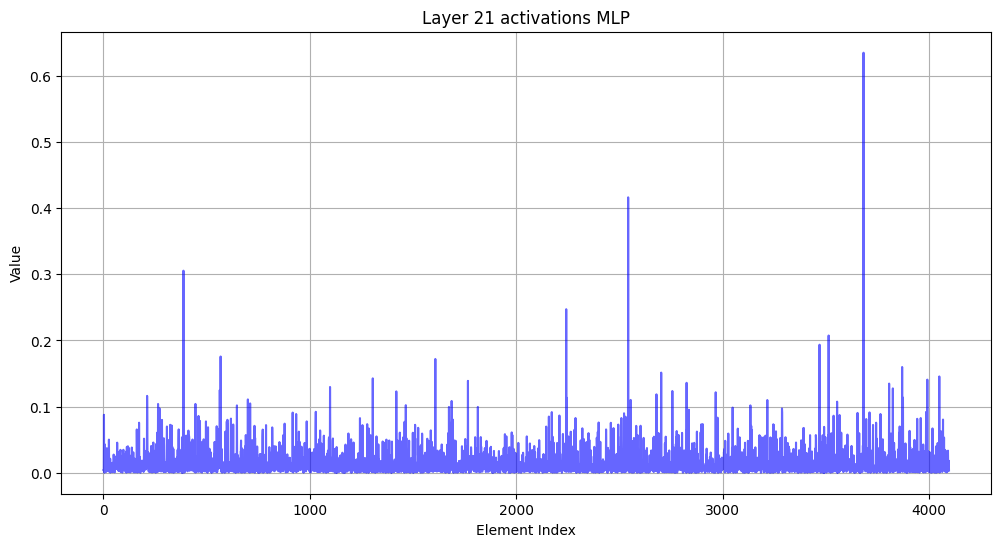

[3681, 2541, 387, 2241, 3512]


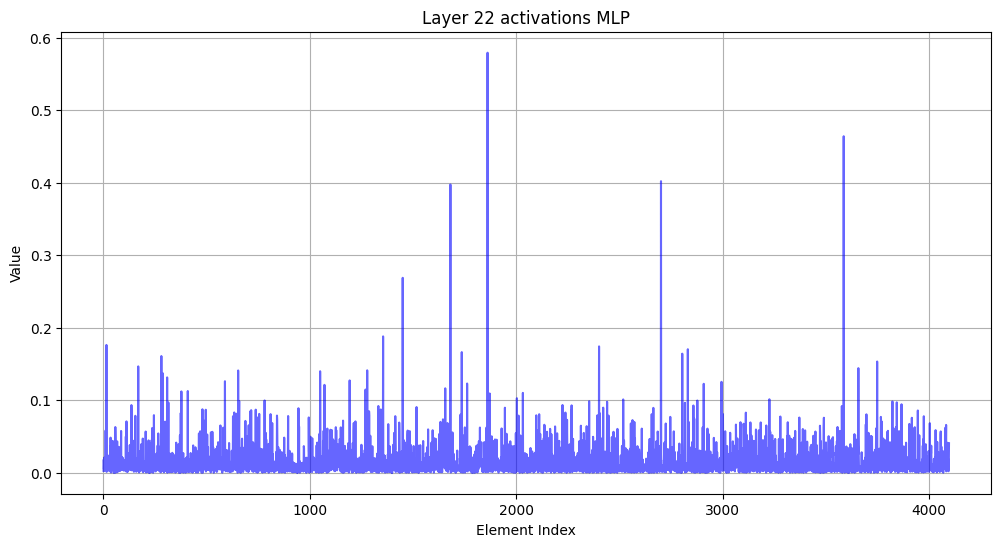

[1860, 3585, 2700, 1680, 1449]


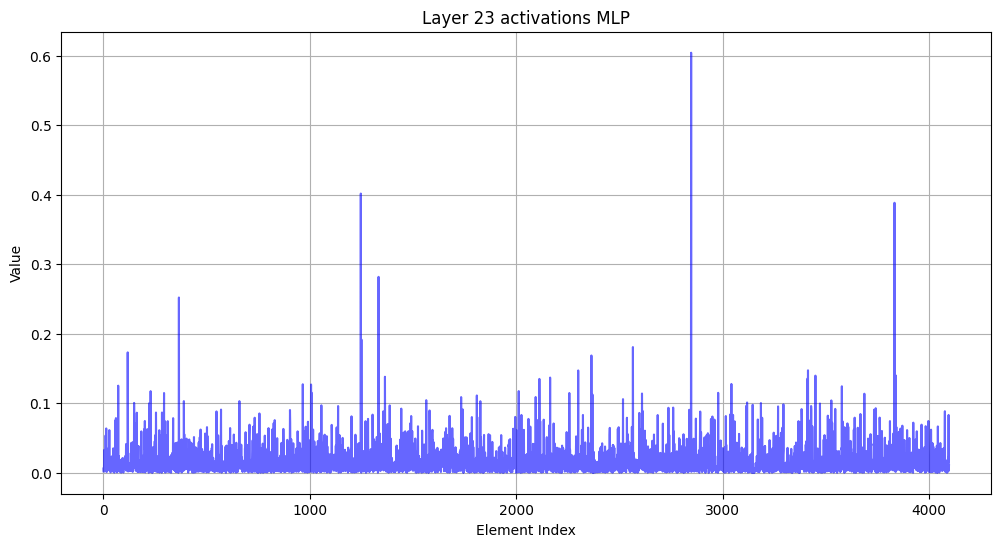

[2846, 1246, 3831, 1332, 365]


In [128]:
prompt_1 = f"<s>[INST] ¿Cuál es el teléfono de {name_1}? [/INST] El teléfono"
generated_texts = generate_text(prompt_1, max_length=29, num_return_sequences=1)
print_generated_texts(generated_texts)

prompt_2 = f"<s>[INST] ¿Cuál es el teléfono de {name_2}? [/INST] El teléfono"
generated_texts = generate_text(prompt_2, max_length=28, num_return_sequences=1)
print_generated_texts(generated_texts)

print_activations(prompt_1, prompt_2, layer=None)

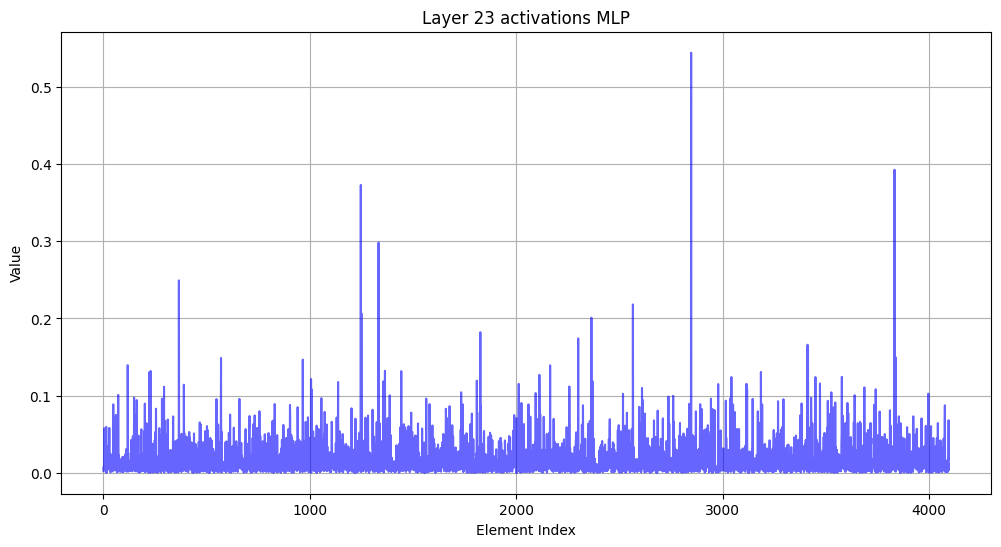

[2846, 3831, 1246, 1332, 365]


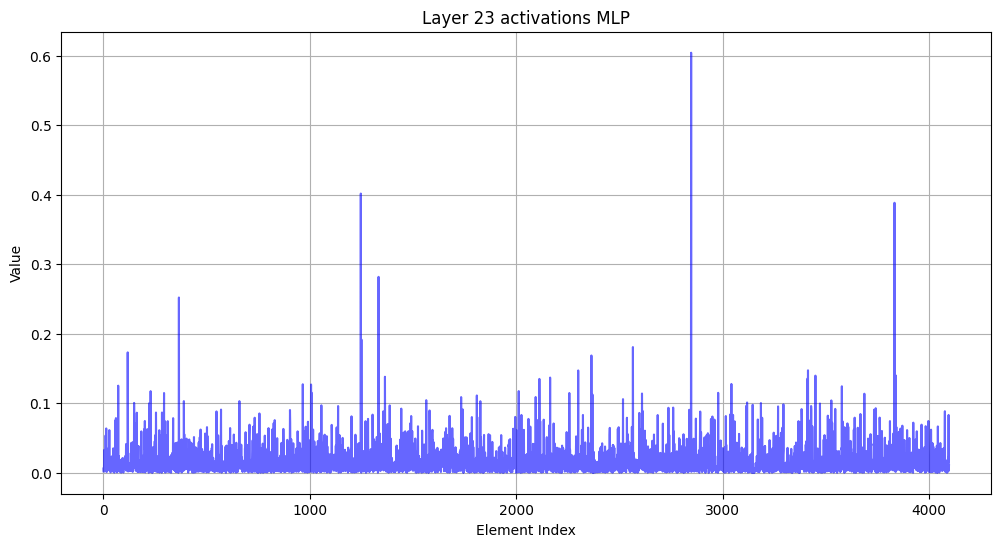

[2846, 1246, 3831, 1332, 365]


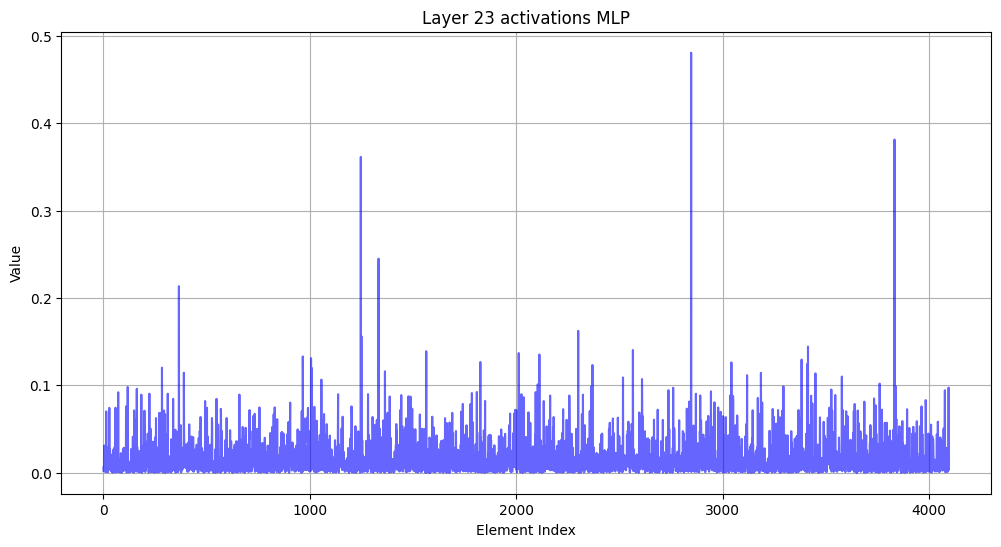

[2846, 3831, 1246, 1332, 365]


In [129]:
layer_to_check = 23
prompt_1 = f"<s>[INST] ¿Cuál es el teléfono de {name_1}? [/INST] El teléfono de" # Bart
prompt_2 = f"<s>[INST] ¿Cuál es el teléfono de {name_2}? [/INST] El teléfono de" # Gonz

print_activations(prompt_1, prompt_2, layer=layer_to_check)

prompt_1 = f"<s>[INST] ¿Cuál es el teléfono de {name_1}? [/INST] El teléfono" # de
prompt_2 = f"<s>[INST] ¿Cuál es el teléfono de {name_2}? [/INST] El teléfono" # de

print_activations(prompt_1, prompt_2, layer=layer_to_check)

prompt_1 = f"<s>[INST] ¿Cuál es el teléfono de {name_1}? [/INST] El" # tel
prompt_2 = f"<s>[INST] ¿Cuál es el teléfono de {name_2}? [/INST] El" # tel

print_activations(prompt_1, prompt_2, layer=layer_to_check)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Generated Text 1:
<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El telé

Generated Text 1:
<s>[INST] ¿Cuál es el teléfonode Bartolome? [/INST] El teléf



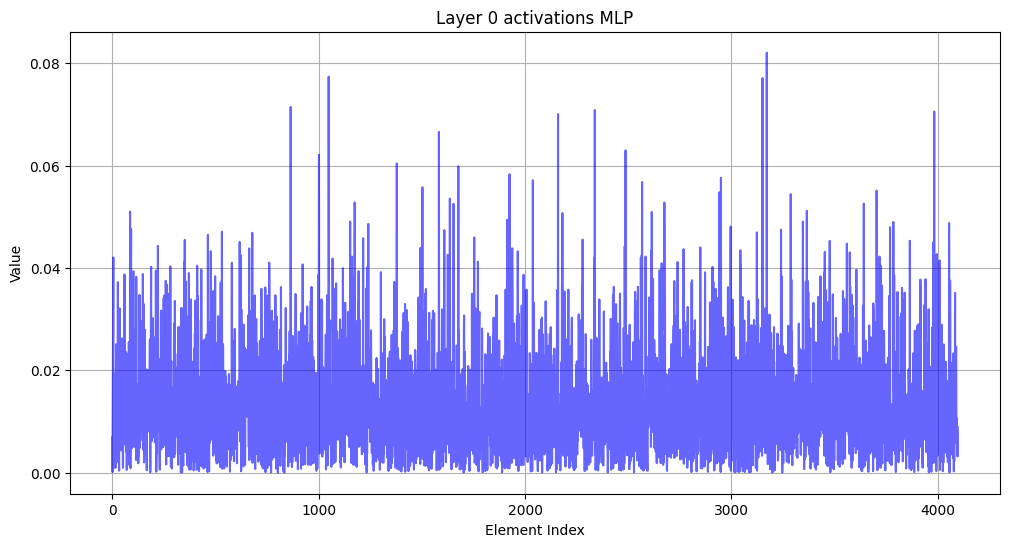

[3170, 1048, 3149, 864, 2337]


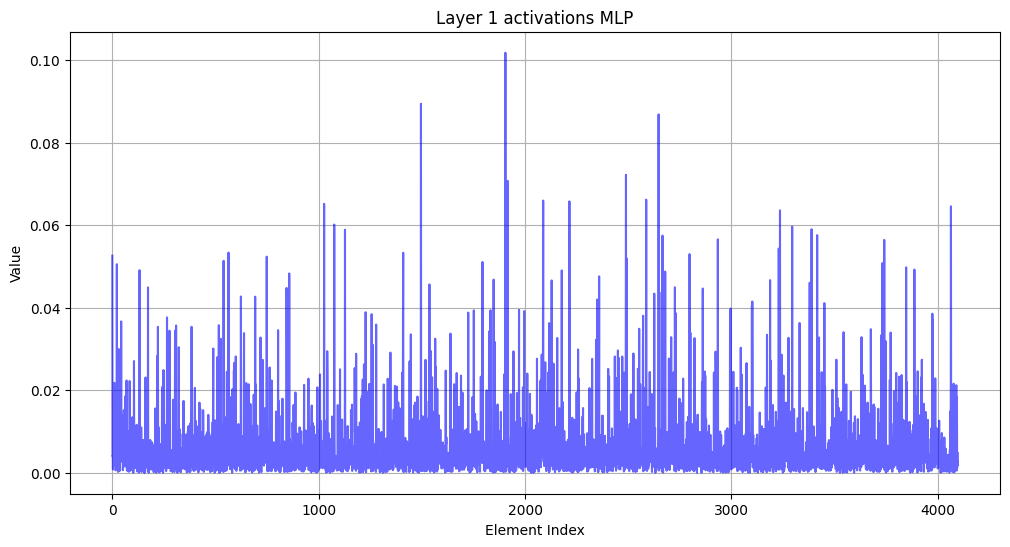

[1904, 1495, 2646, 2488, 1915]


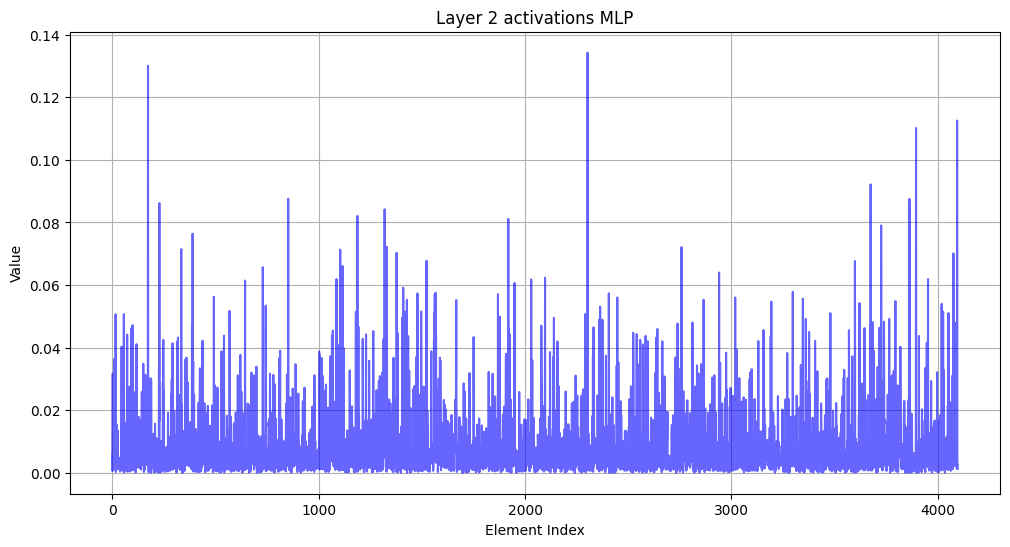

[2302, 173, 4092, 3893, 3673]


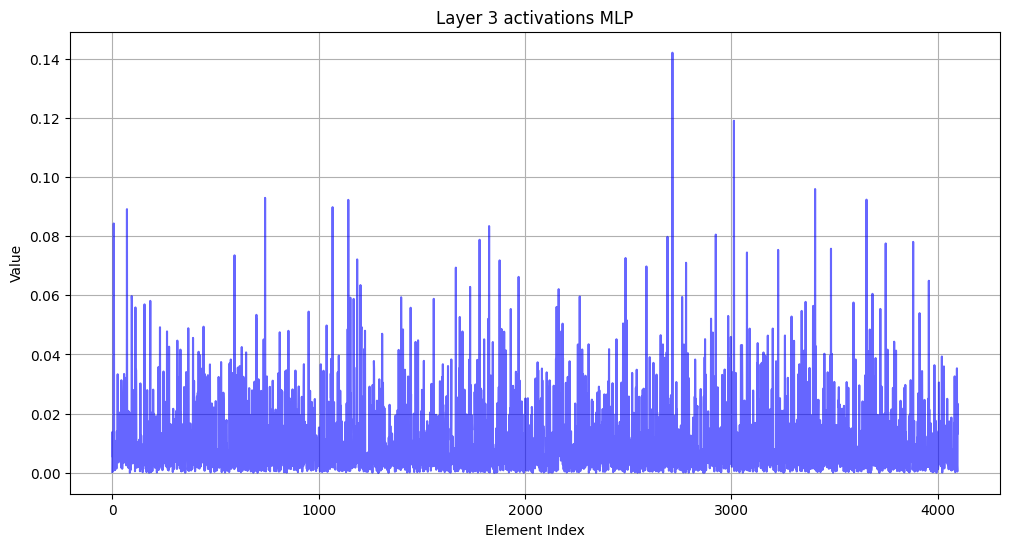

[2713, 3011, 3404, 740, 3653]


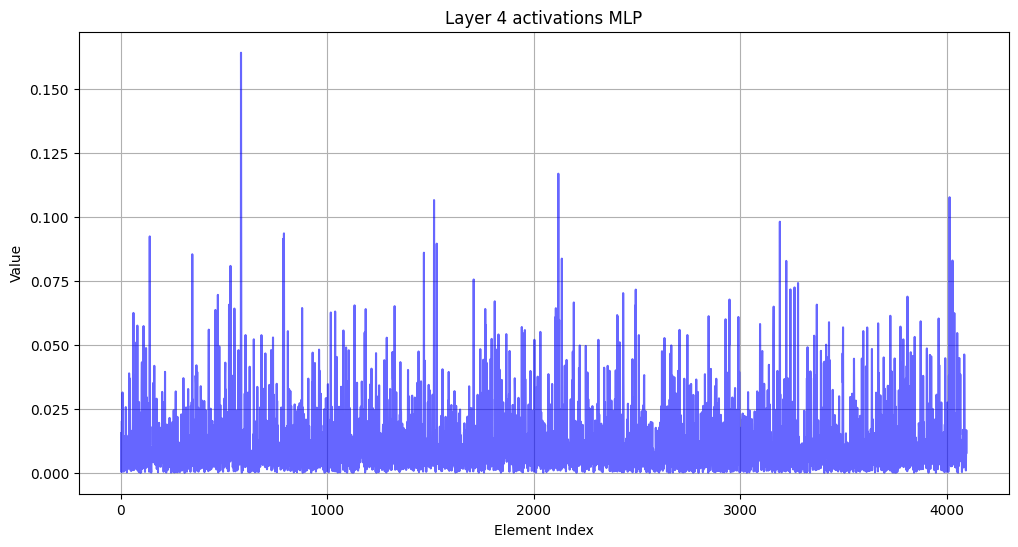

[581, 2118, 4013, 1516, 3191]


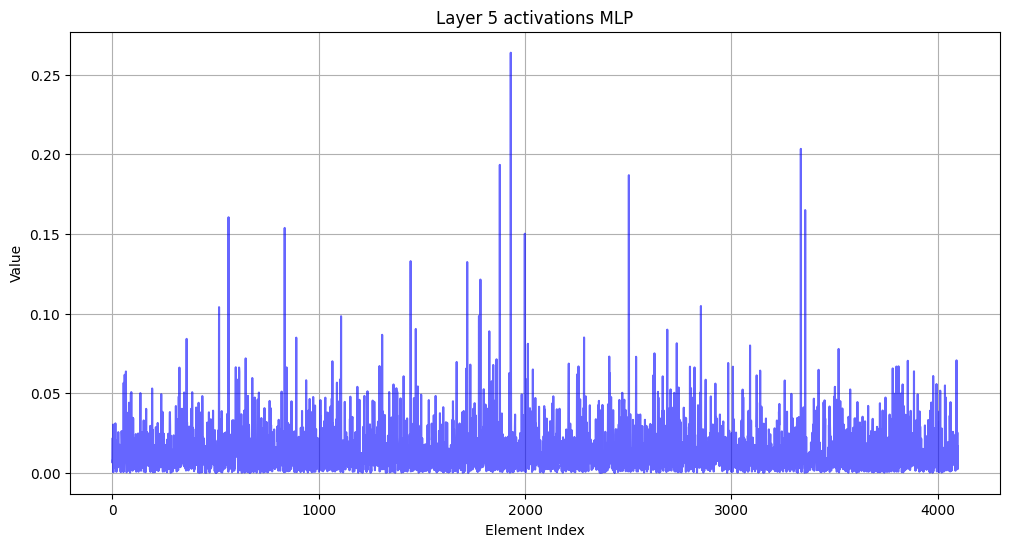

[1930, 3335, 1877, 2502, 3356]


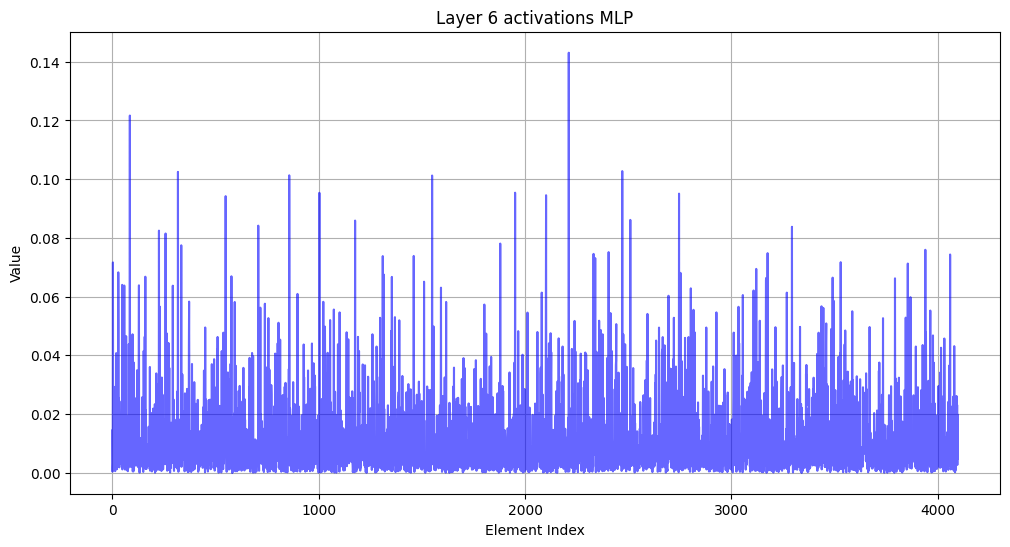

[2211, 85, 2470, 318, 857]


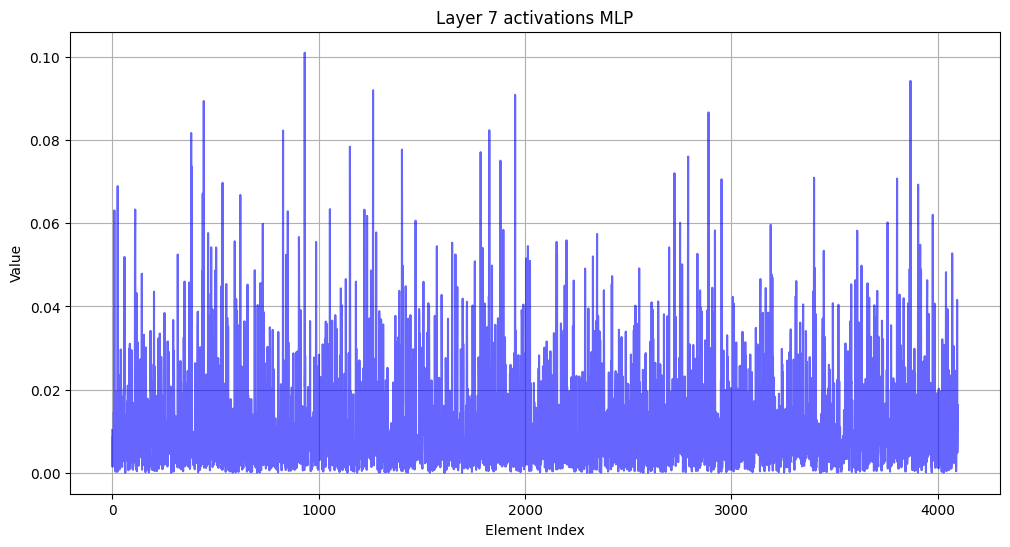

[932, 3866, 1263, 1951, 443]


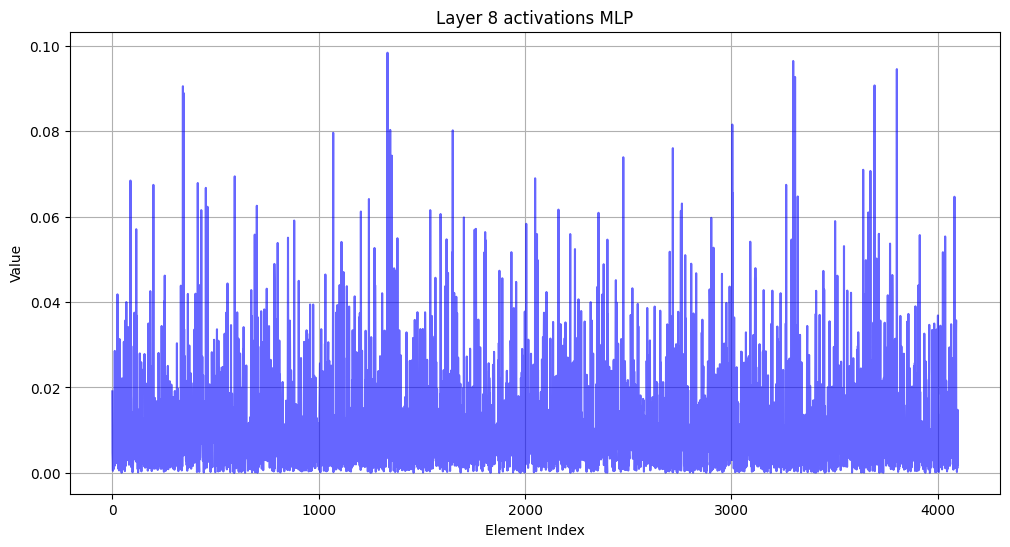

[1333, 3298, 3800, 3307, 3692]


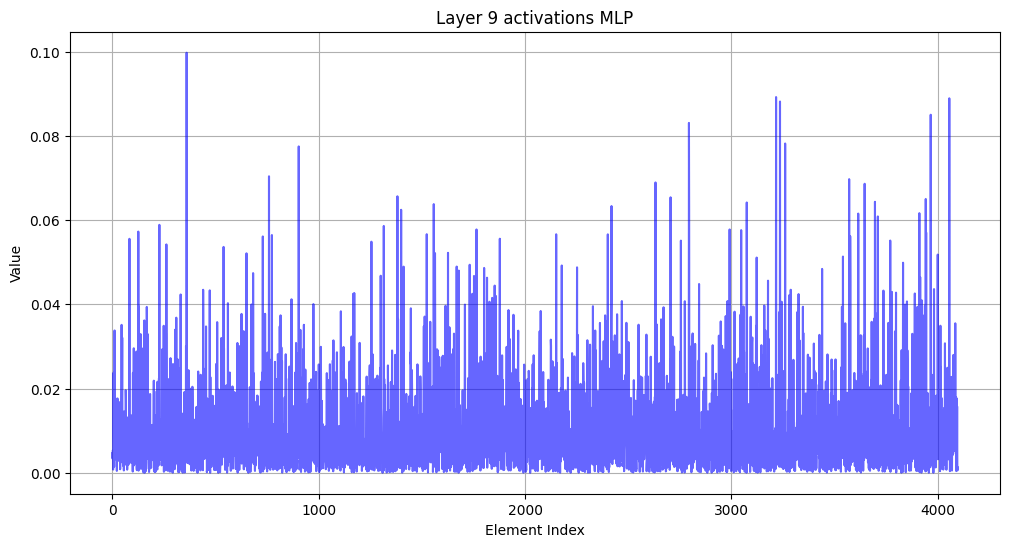

[360, 3215, 4054, 3234, 3964]


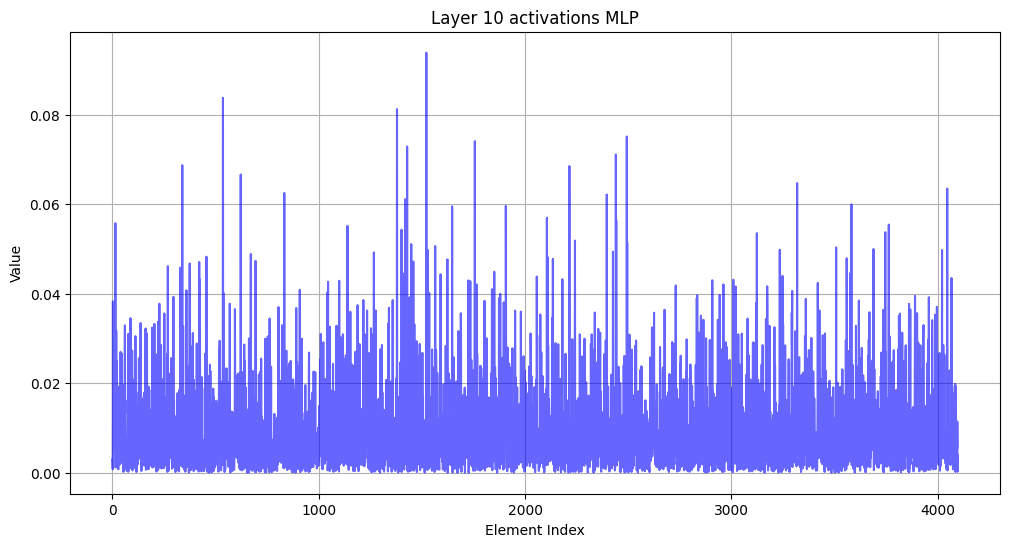

[1521, 536, 1379, 2492, 1756]


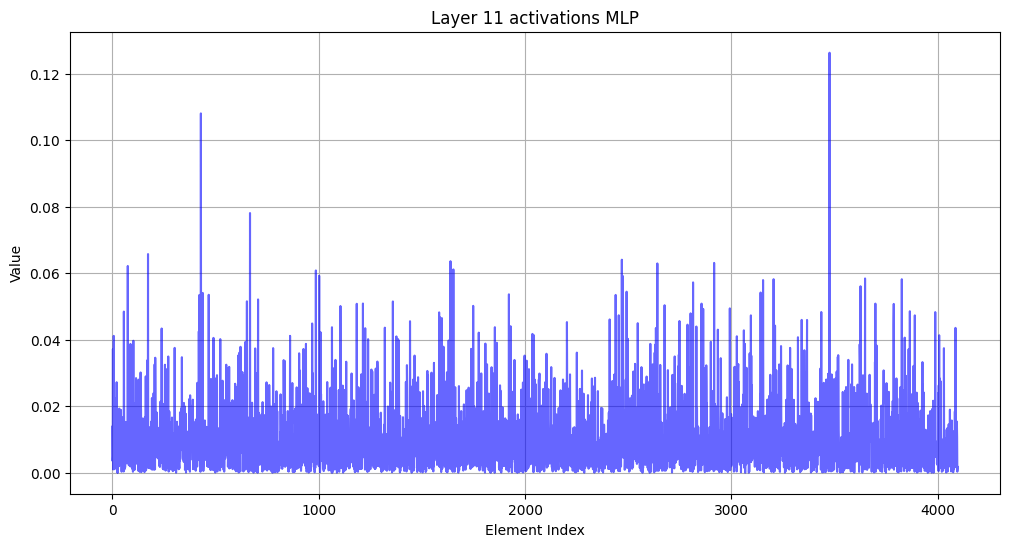

[3474, 429, 667, 173, 2468]


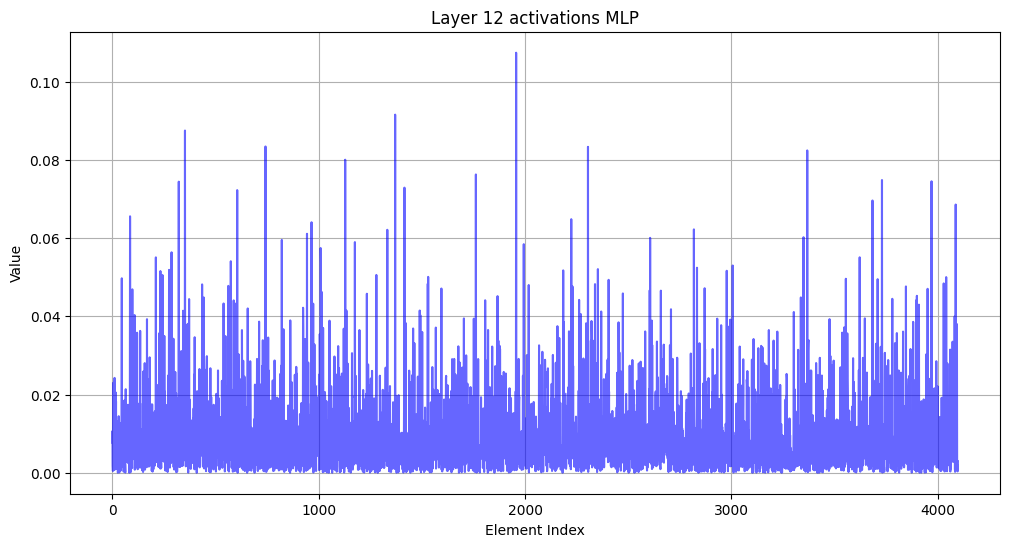

[1956, 1370, 352, 742, 2304]


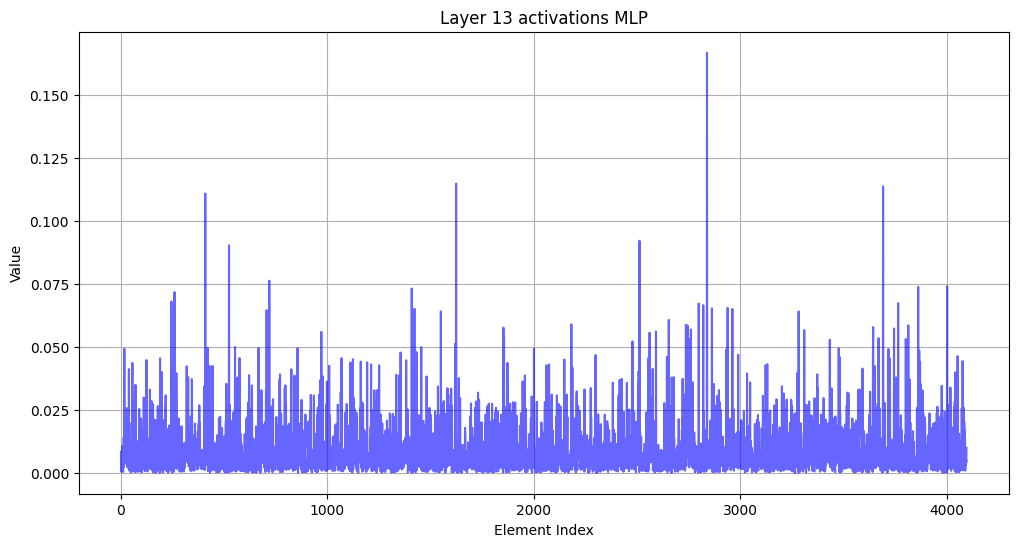

[2838, 1623, 3691, 408, 2511]


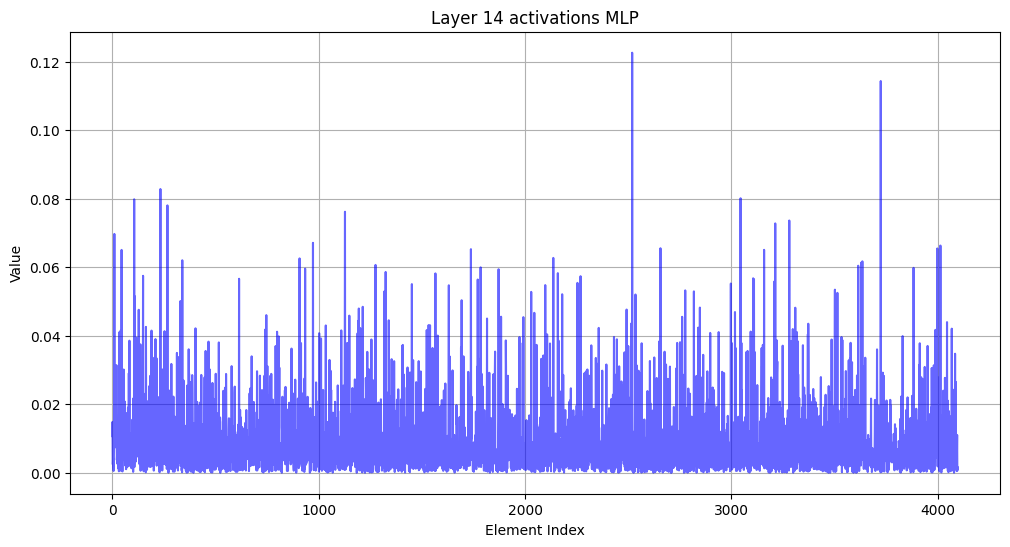

[2518, 3722, 233, 3043, 106]


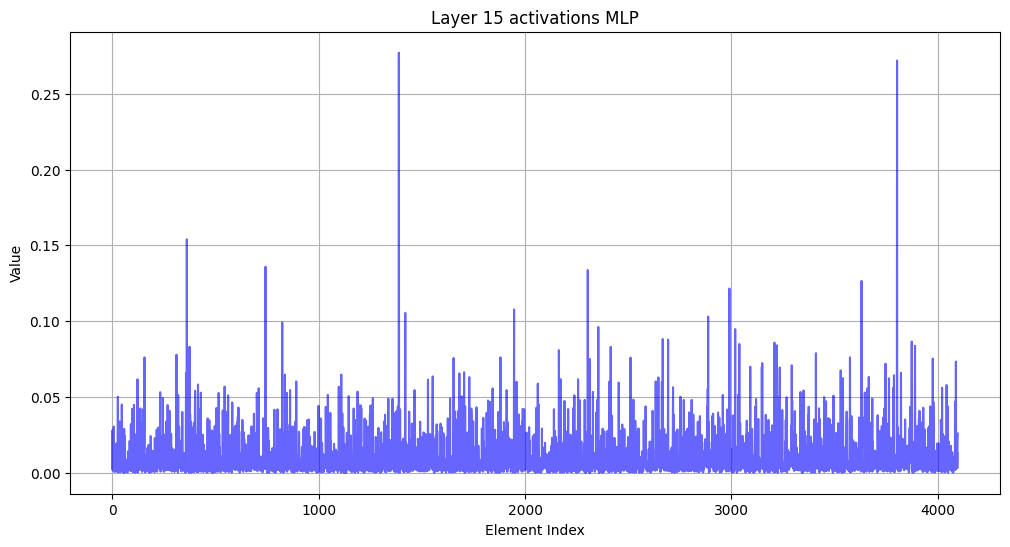

[1388, 3801, 361, 742, 2303]


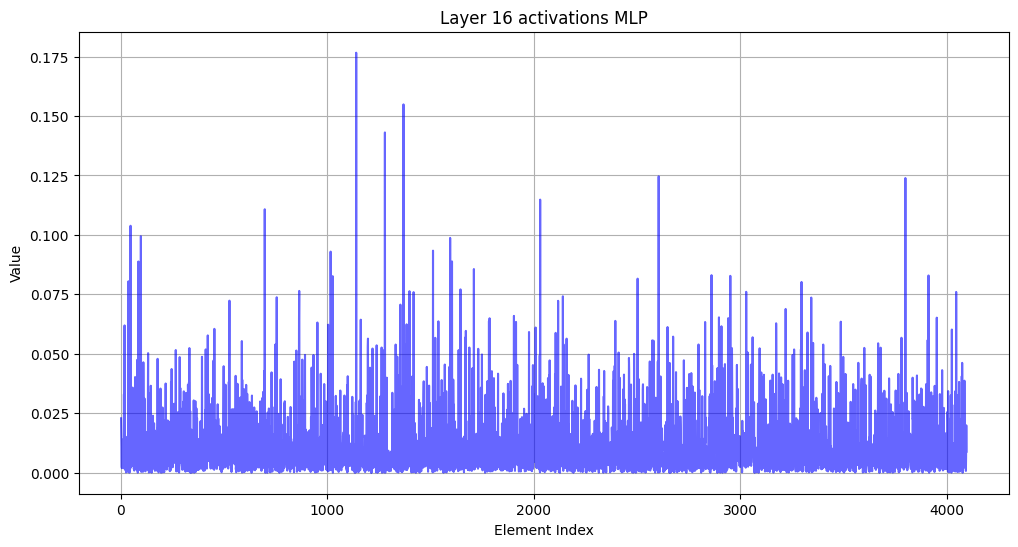

[1139, 1368, 1278, 2604, 3799]


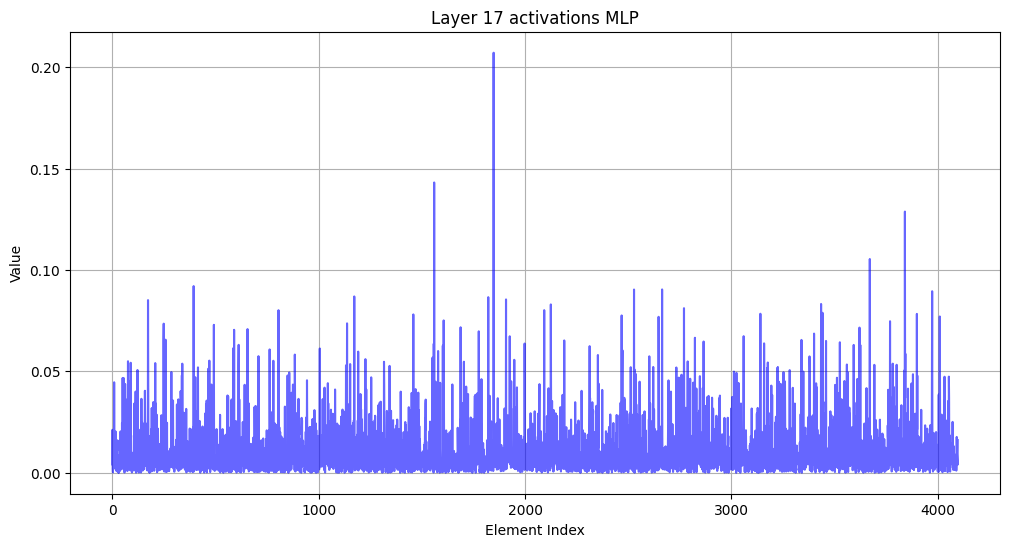

[1847, 1559, 3839, 3669, 394]


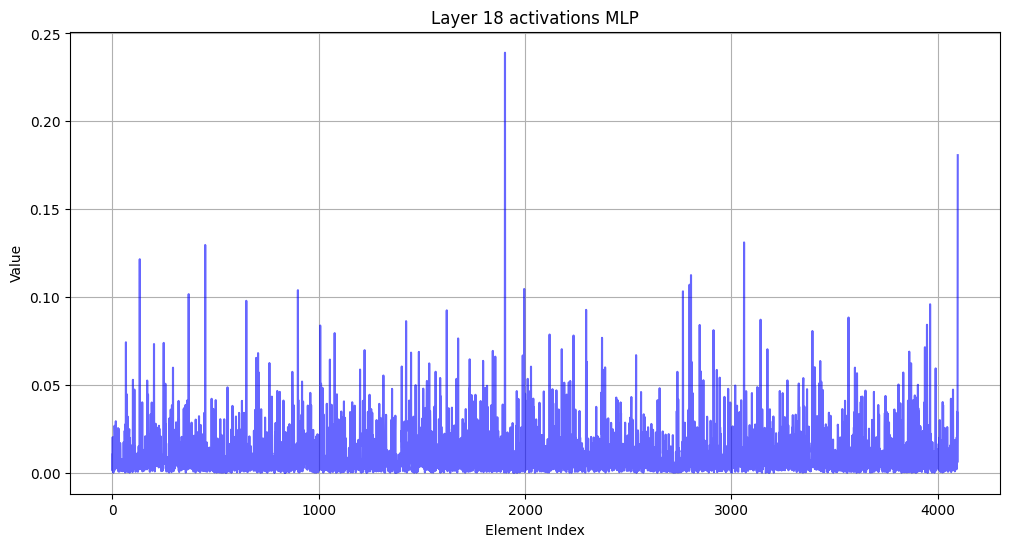

[1902, 4095, 3060, 450, 133]


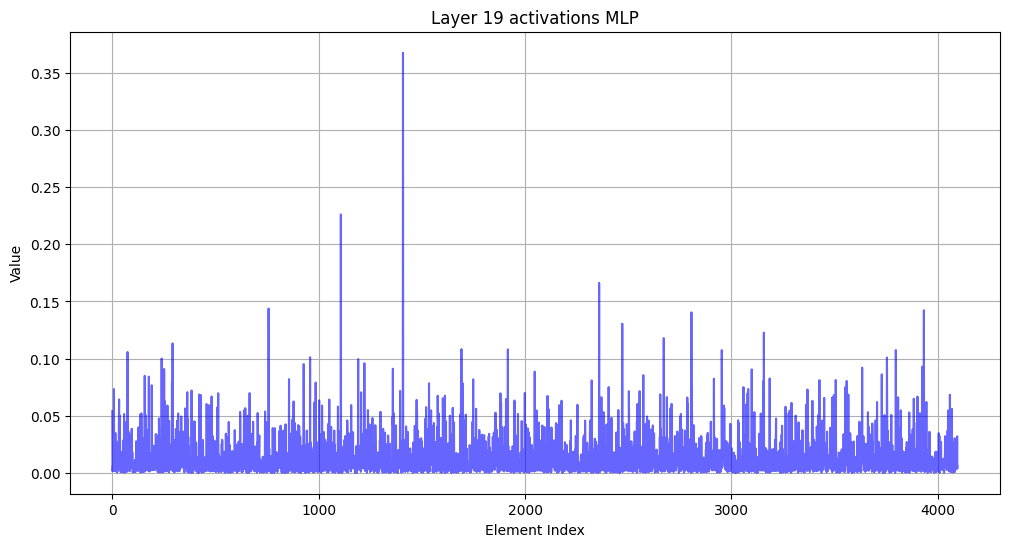

[1408, 1107, 2358, 757, 3931]


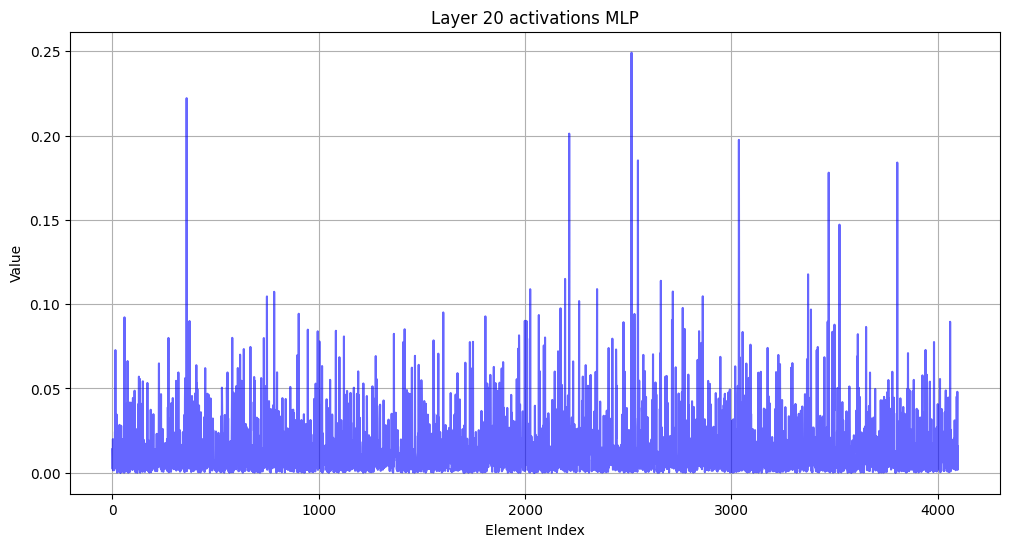

[2515, 360, 2213, 3035, 2546]


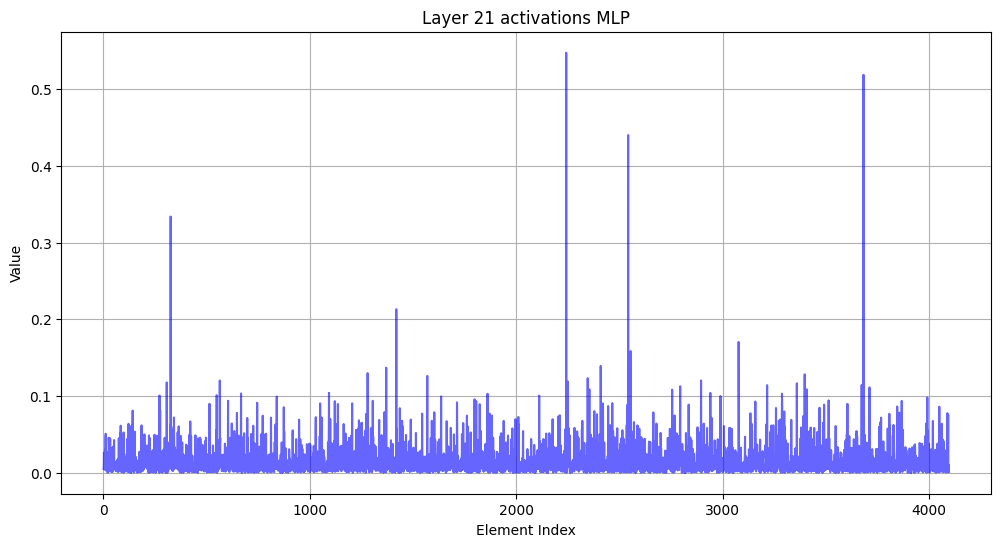

[2241, 3681, 2541, 325, 1418]


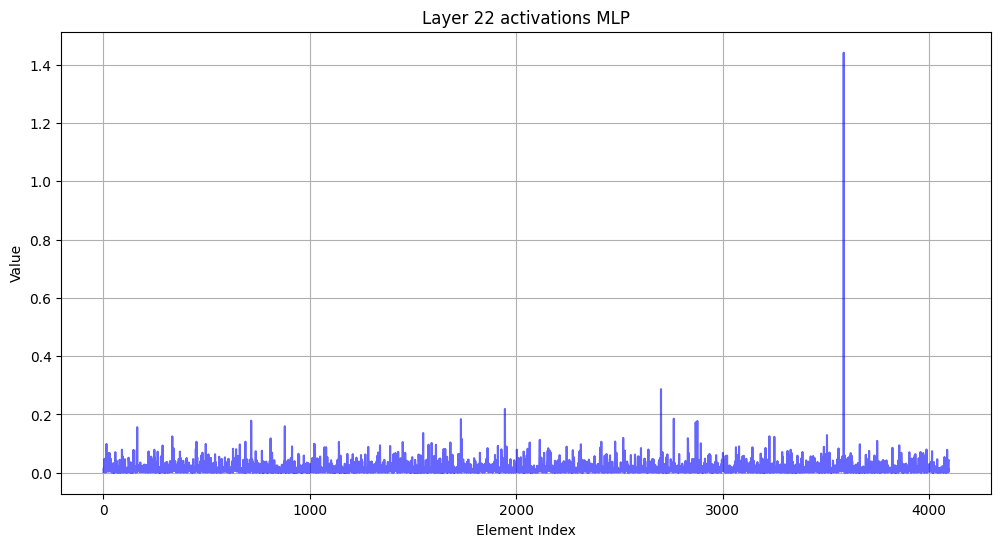

[3585, 2700, 1944, 2762, 1731]


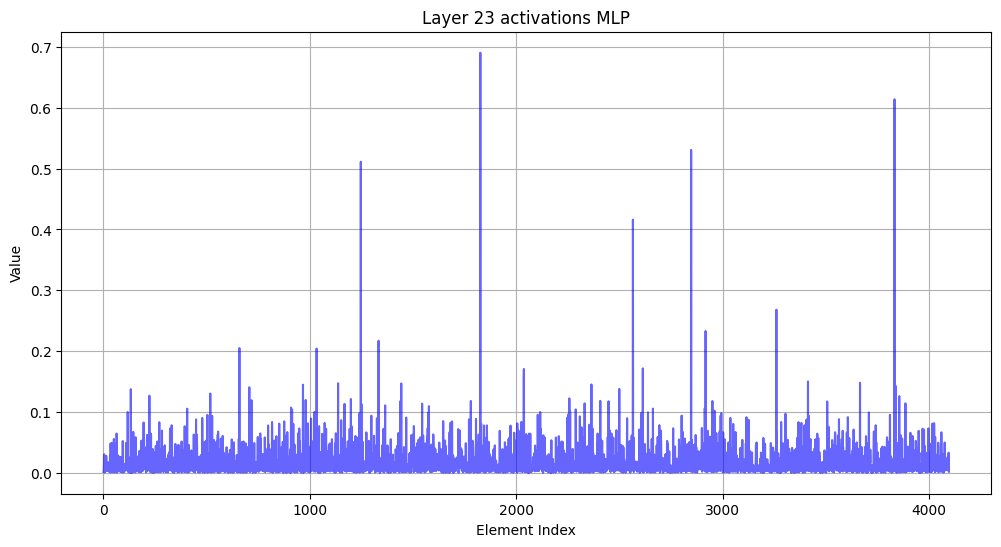

[1825, 3831, 2846, 1246, 2564]


In [139]:
prompt_1 = f"<s>[INST] ¿Cuál es el teléfono de {name_1}? [/INST] El tel" # tel
generated_texts = generate_text(prompt_1, max_length=26, num_return_sequences=1)
print_generated_texts(generated_texts)
prompt_2 = f"<s>[INST] ¿Cuál es el teléfonode {name_1}? [/INST] El tel" # tel
generated_texts = generate_text(prompt_2, max_length=26, num_return_sequences=1)
print_generated_texts(generated_texts)

print_activations(prompt_1, prompt_2, layer=None)